<a href="https://colab.research.google.com/github/JacekPardyak/tb-data-science-talks/blob/master/2022-06-09/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dutch restaurants reviews analysis
We want to know if from *Review text* written by a restaurant guest we can conclude anything about *Food* quality? 

## Install and load packages


In [1]:
if(!require(tidytext)) install.packages('tidytext')
if(!require(stopwords)) install.packages('stopwords')
if(!require(wordcloud)) install.packages('wordcloud')
if(!require(igraph)) install.packages('igraph')
if(!require(ggraph)) install.packages('ggraph')
if(!require(rsample)) install.packages('rsample')
if(!require(glmnet)) install.packages('glmnet')
if(!require(doMC)) install.packages('doMC')
if(!require(yardstick)) install.packages('yardstick')

library(tidyverse) # tables manipulation
library(tidytext) # text manipulation
library(wordcloud) # to create and plot wordcloud
library(forcats) # for inverse document frequency
library(igraph) # to create graphs
library(ggraph) # to plot graph objects
library(rsample) # to sample data
library(glmnet) # fit a generalized linear model
library(doMC) # parallel computing
library(yardstick) # for model performance
library(broom) # to tidy the output
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300) # set size of plots

Loading required package: tidytext

Loading required package: stopwords

Loading required package: wordcloud

Loading required package: RColorBrewer

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggraph

Loading required package: ggplot2

Loading required package: rsample

Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 4.1-4

Loading required package: doMC

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Loading required package: yardstick

For binary classification, the first factor level is assumed to be the event.
Use the argument `event_level = "second"` to alter this as needed.

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching package

## Down- and -load the data

In [2]:
# data source https://www.theanalyticslab.nl/nlpblogs_0_preparing_restaurant_review_data_for_nlp_and_predictive_modeling/
# the encoding issue has been fixed.
system("wget --continue https://github.com/JacekPardyak/tb-data-science-talks/raw/master/2022-06-09/reviews.csv.gz -O /tmp/reviews.csv.gz")
reviews <- read_csv("/tmp/reviews.csv.gz")
reviews %>% head()

Rows: 339524 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (8): restoName, tags, address, valueForPriceScore, noiseLevelScore, wa...
dbl  (15): restoId, scoreTotal, avgPrice, numReviews, scoreFood, scoreServic...
dttm  (1): reviewDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


restoId,restoName,tags,address,scoreTotal,avgPrice,numReviews,scoreFood,scoreService,scoreDecor,⋯,waitingTimeScore,reviewerId,reviewerFame,reviewerNumReviews,reviewDate,reviewScoreOverall,reviewScoreFood,reviewScoreService,reviewScoreAmbiance,reviewText
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
255757,India Palace,Indiaas|zakenlunch|Live muziek|Met familie|Met vrienden|provincie Zuid-Holland|Terras|Tuin,Natuursteenlaan 157 2719 TB Zoetermeer Nederland,8,24,57,82,77,77,⋯,NA,111436837,Fijnproever,3,2017-12-24 23:00:00,9,10,8,8,heerlijk eten en leuke sfeer veel keuze bij het buffet en toetjes ook heel goed werd steeds aangevuld en was vers vriendelijk personeel ik kom zeker teruy enige misleidende op de website is dat drinken niet inclusief was het is bericht uit 2016 zijn waar dat wel bij stond maar jaartal werd niet vermeld dus ik en vele anderen dachten dat het nu ook geldt
255757,India Palace,Indiaas|zakenlunch|Live muziek|Met familie|Met vrienden|provincie Zuid-Holland|Terras|Tuin,Natuursteenlaan 157 2719 TB Zoetermeer Nederland,8,24,57,82,77,77,⋯,NA,111280499,Fijnproever,2,2017-11-16 23:00:00,10,10,10,10,met z'n vieren dit restaurant bezocht we hadden de butter chicken de mixed grill en groente besteld het eten was geweldig lekker iets minder gekruid maar ging wel de service is goed oplettend en vriendelijk de indiase bier en lassi niet te vergeten vicky wij komen terug
255757,India Palace,Indiaas|zakenlunch|Live muziek|Met familie|Met vrienden|provincie Zuid-Holland|Terras|Tuin,Natuursteenlaan 157 2719 TB Zoetermeer Nederland,8,24,57,82,77,77,⋯,NA,111271663,Meesterproever,12,2017-08-21 22:00:00,75,8,6,8,snel gegeten tijdens een plotselinge bezoek naar zoetermeer eten was niet zo bijzonder maar ja als je honger hebt moet het maar.de bediening is traag.niet een tweede keer
255757,India Palace,Indiaas|zakenlunch|Live muziek|Met familie|Met vrienden|provincie Zuid-Holland|Terras|Tuin,Natuursteenlaan 157 2719 TB Zoetermeer Nederland,8,24,57,82,77,77,⋯,NA,123554609,Proever,1,2017-08-19 22:00:00,25,2,2,4,wait to be seated we moesten lang wachten.ontvangen door spraakloze ober kwam met volle mond uit de keuken later bleek dat hij ook geen nederlands sprak werden naar een tafeltje gewuifd en moesten toen lang wachten voor hij drankjes op kwam nemen terwijl het restaurant maar zeer matig bezet was we kozen voor het buffet a 19 50 wat een aanfluiting alles koud onder geen enkel gerecht een brander die aan was een 1 soort rijst 1 tandoori gerecht 2 andere vleessoorten currie dreef in de olie met specerijen probeerde men de smaak wat op te krikken smakeloze saag paneer kikkererwten van een paar dagen oud als je op de smaak af gaat totale desinteresse bij ober geen sfeer slecht onder houden parkeerplaats en tuin groezelig interieur kortom we hebben spijt dat we daar waren
255757,India Palace,Indiaas|zakenlunch|Live muziek|Met familie|Met vrienden|provincie Zuid-Holland|Terras|Tuin,Natuursteenlaan 157 2719 TB Zoetermeer Nederland,8,24,57,82,77,77,⋯,NA,111214501,Proever,1,2017-08-18 22:00:00,3,2,2,6,wij zijn volgens ons afspraak om 18.00 uur daar verschenen helaas werd er op locatie tegen ons gezegd dat er alleen lopend buffet was aangezien we al gereserveerd hadden waren we akkoord gegaan na een minuut kwam serveerster onverzorgd uitziende oud vrouwtje naar ons met de mededeling dat het zeker een uur gaat duren voordat er geserveerd gaat worden er was ook verder niemand aanwezig sorry hier gaan we niet eten we zijn weggegaan
255757,India Palace,Indiaas|zakenlunch|Live muziek|Met familie|Met vrienden|provincie Zuid-Holland|Terras|Tuin,Natuursteenlaan 157 2719 TB Zoetermeer Nederland,8,24,57,82,77,77,⋯,NA,112751455,Fijnproever,2,2017-08-05 22:00:00,9,10,8,8,heerlijk gegeten


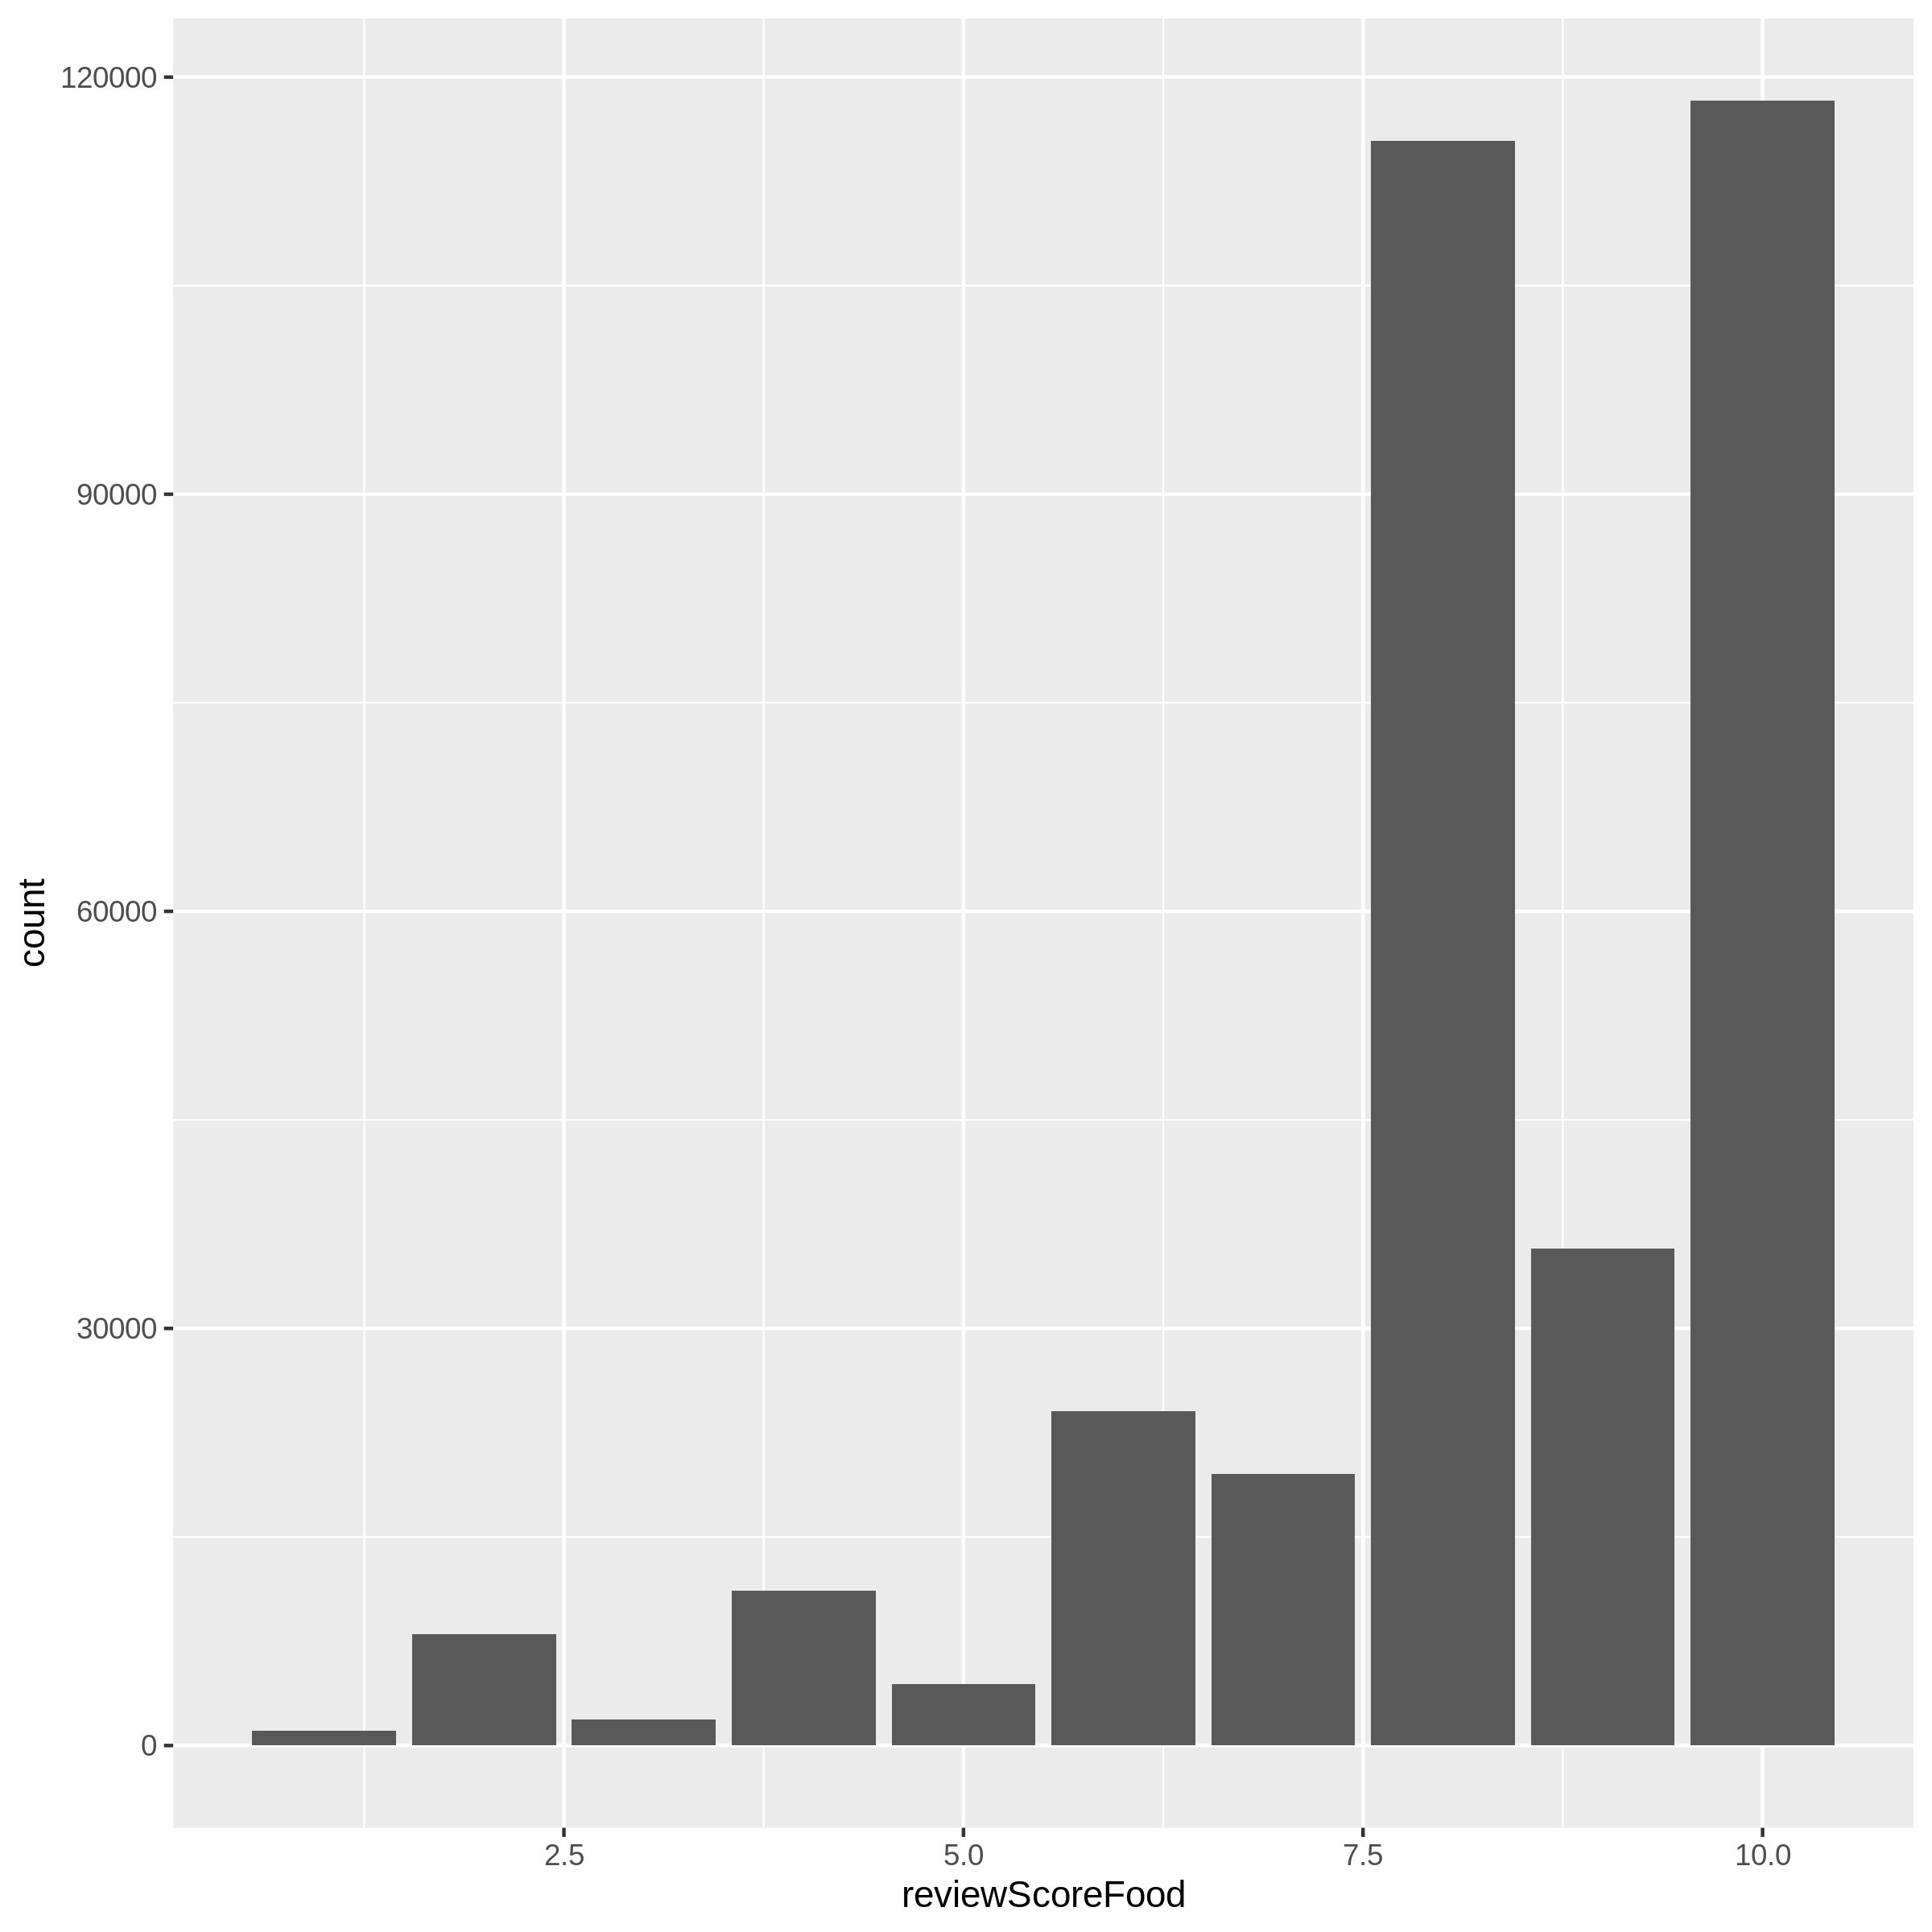

In [3]:
# check food score distribution
reviews %>% ggplot() +
  aes(x = reviewScoreFood) +
  geom_bar()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




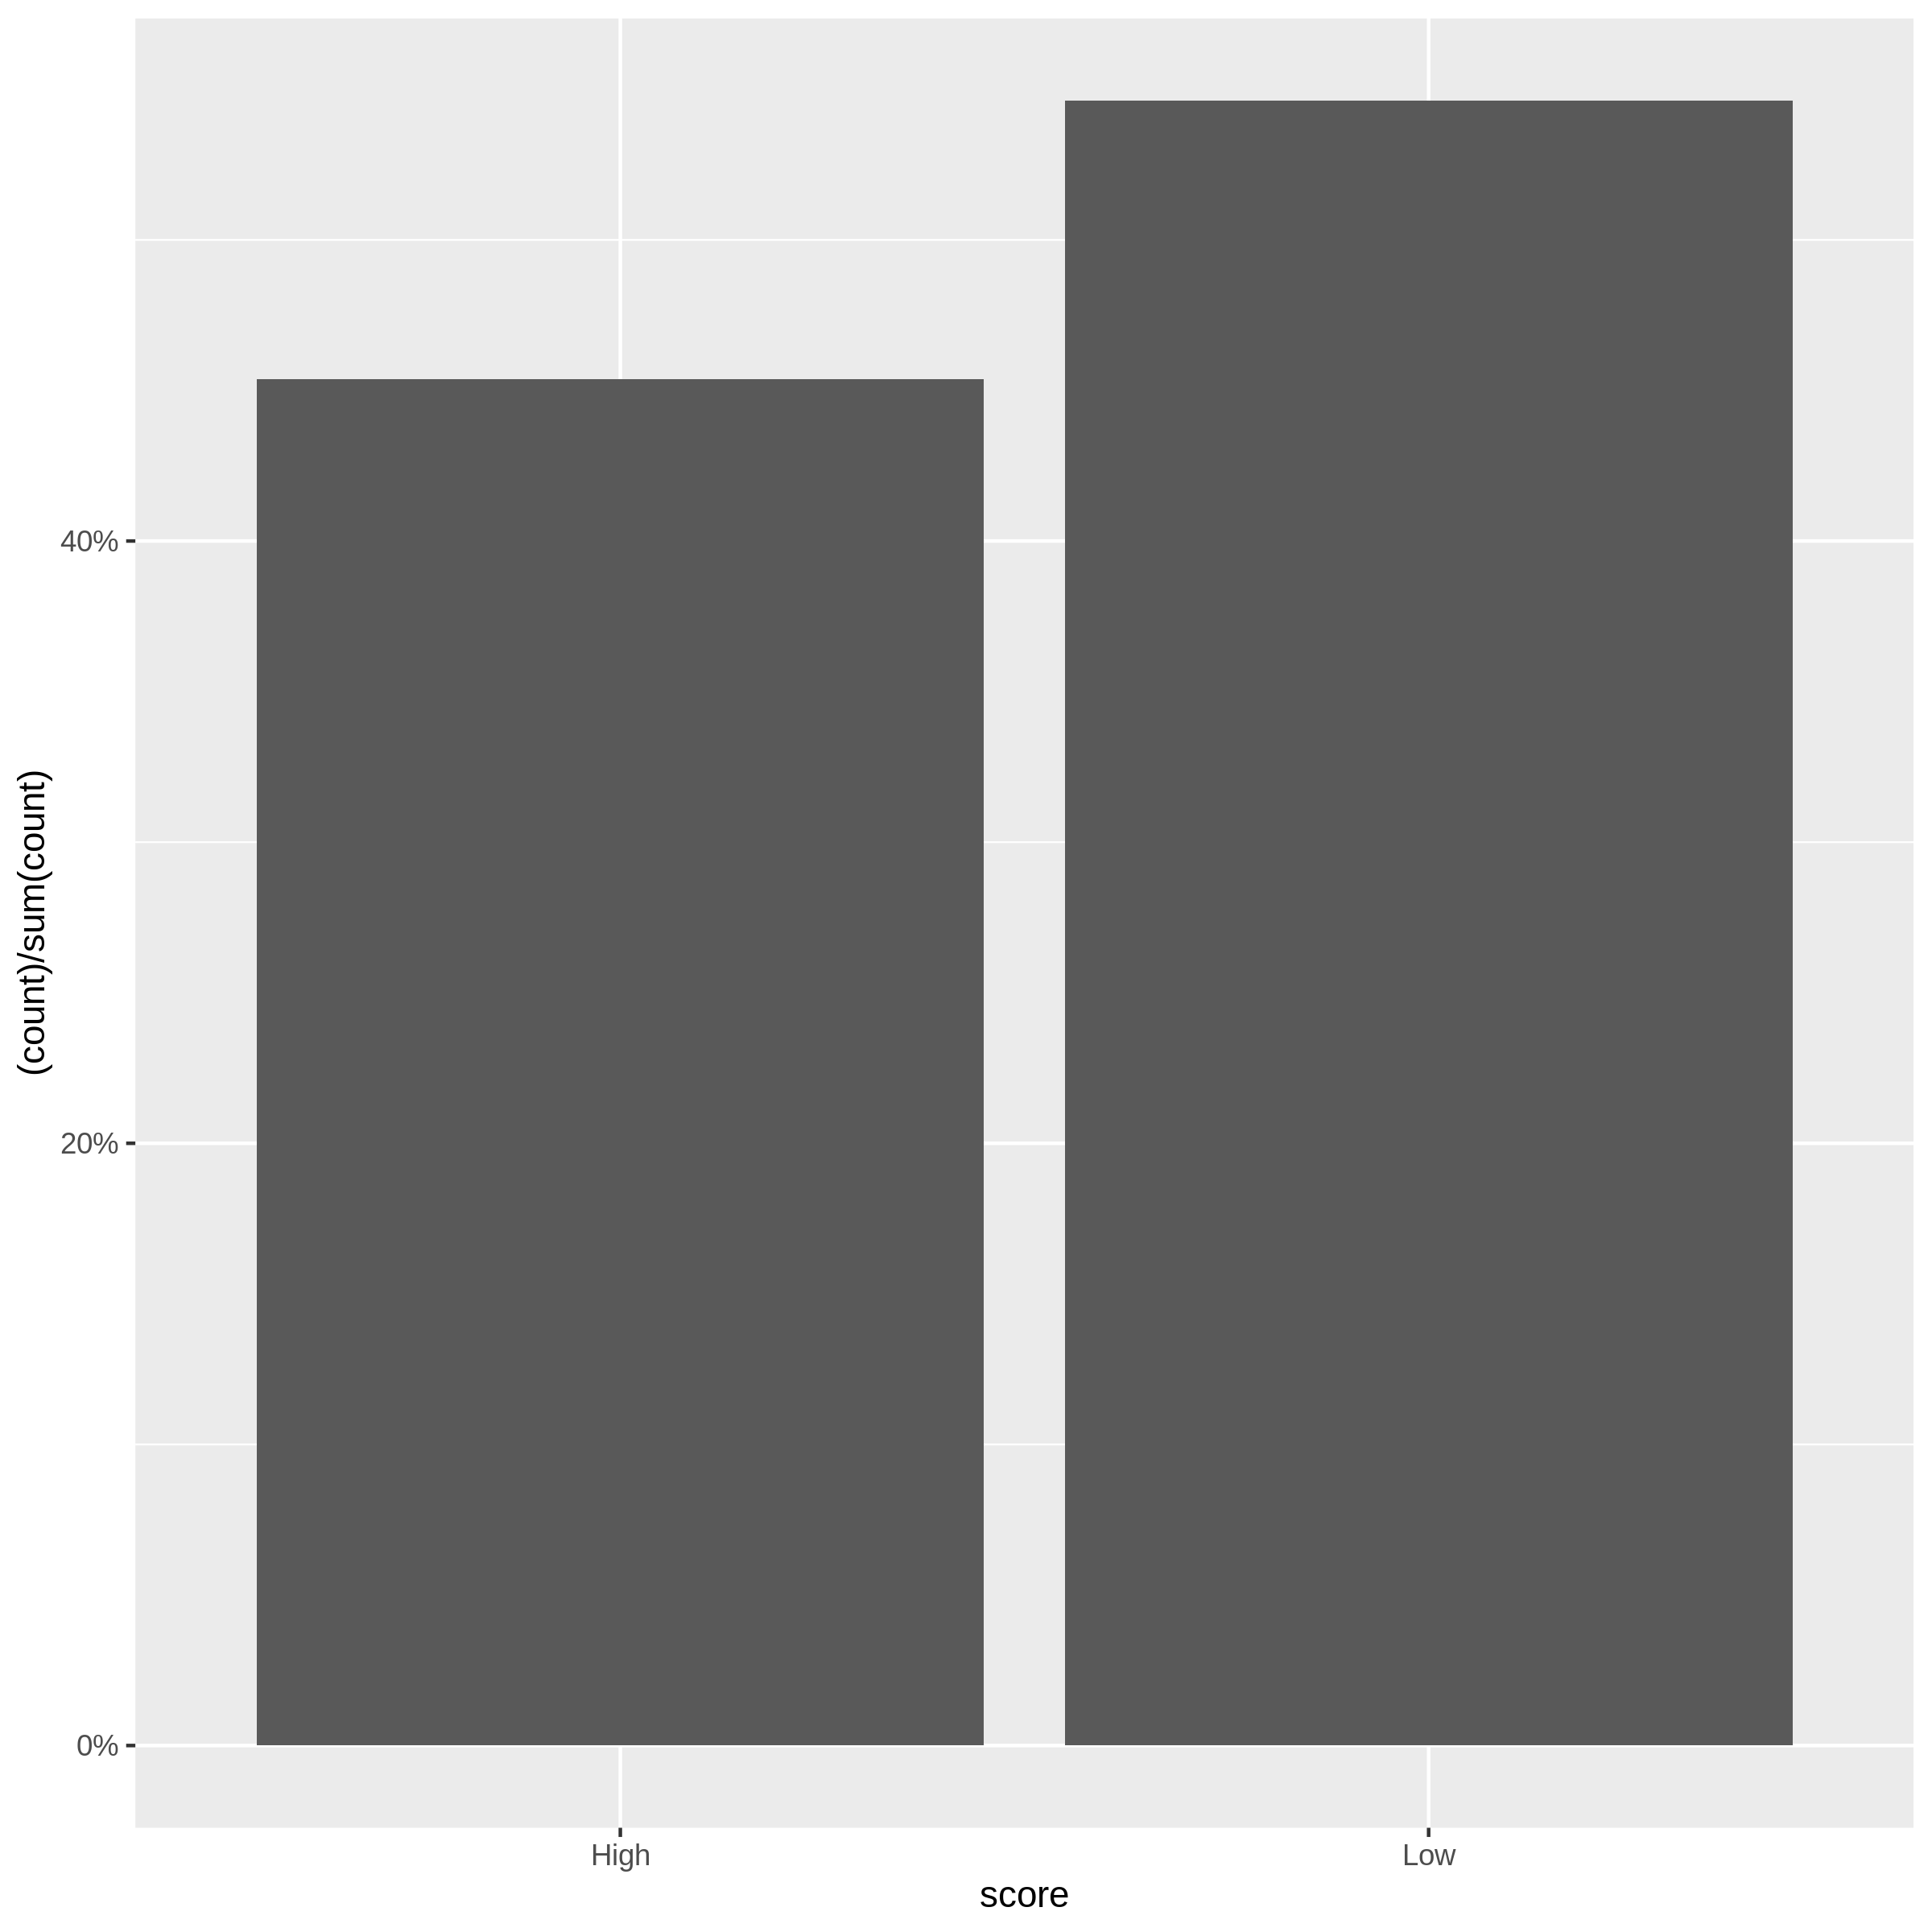

In [4]:
# check binned food score distribution
library(scales)
reviews %>% mutate(score = if_else(reviewScoreFood > 8, "High", "Low")) %>% 
  ggplot() +
  aes(x = score) + 
  geom_bar(aes(y = (..count..)/sum(..count..))) +
  scale_y_continuous(labels = percent)

# Text mining

In [5]:
# tokenize review text
my_stop_words = c("we", "wij")
stop_words = tibble(word = c(stopwords::stopwords("nl", source = "snowball"), my_stop_words))

tidy_data <- reviews %>% 
  mutate(score = if_else(reviewScoreFood > 8, "High", "Low")) %>%
  select(score, reviewText) %>%
  unnest_tokens(word, reviewText) %>%
  group_by(word) %>%
  filter(n() > 10) %>%
  ungroup() %>% 
  anti_join(stop_words)

tidy_data %>% head()

Joining, by = "word"


score,word
<chr>,<chr>
High,heerlijk
High,eten
High,leuke
High,sfeer
High,keuze
High,buffet


In [6]:
# Term frequency (tf)
word_count <- tidy_data %>% 
  count(word, sort = TRUE)
word_count %>% head()

word,n
<chr>,<int>
eten,186138
bediening,150111
goed,134036
gegeten,119545
lekker,115859
heerlijk,113649


In [7]:
# Term frequency (tf) by score
score_count <- tidy_data %>% 
  count(score, word, sort = TRUE)
score_count %>% head()

score,word,n
<chr>,<chr>,<int>
Low,eten,110298
Low,bediening,84924
Low,goed,83071
High,eten,75840
High,heerlijk,72201
Low,wel,71133


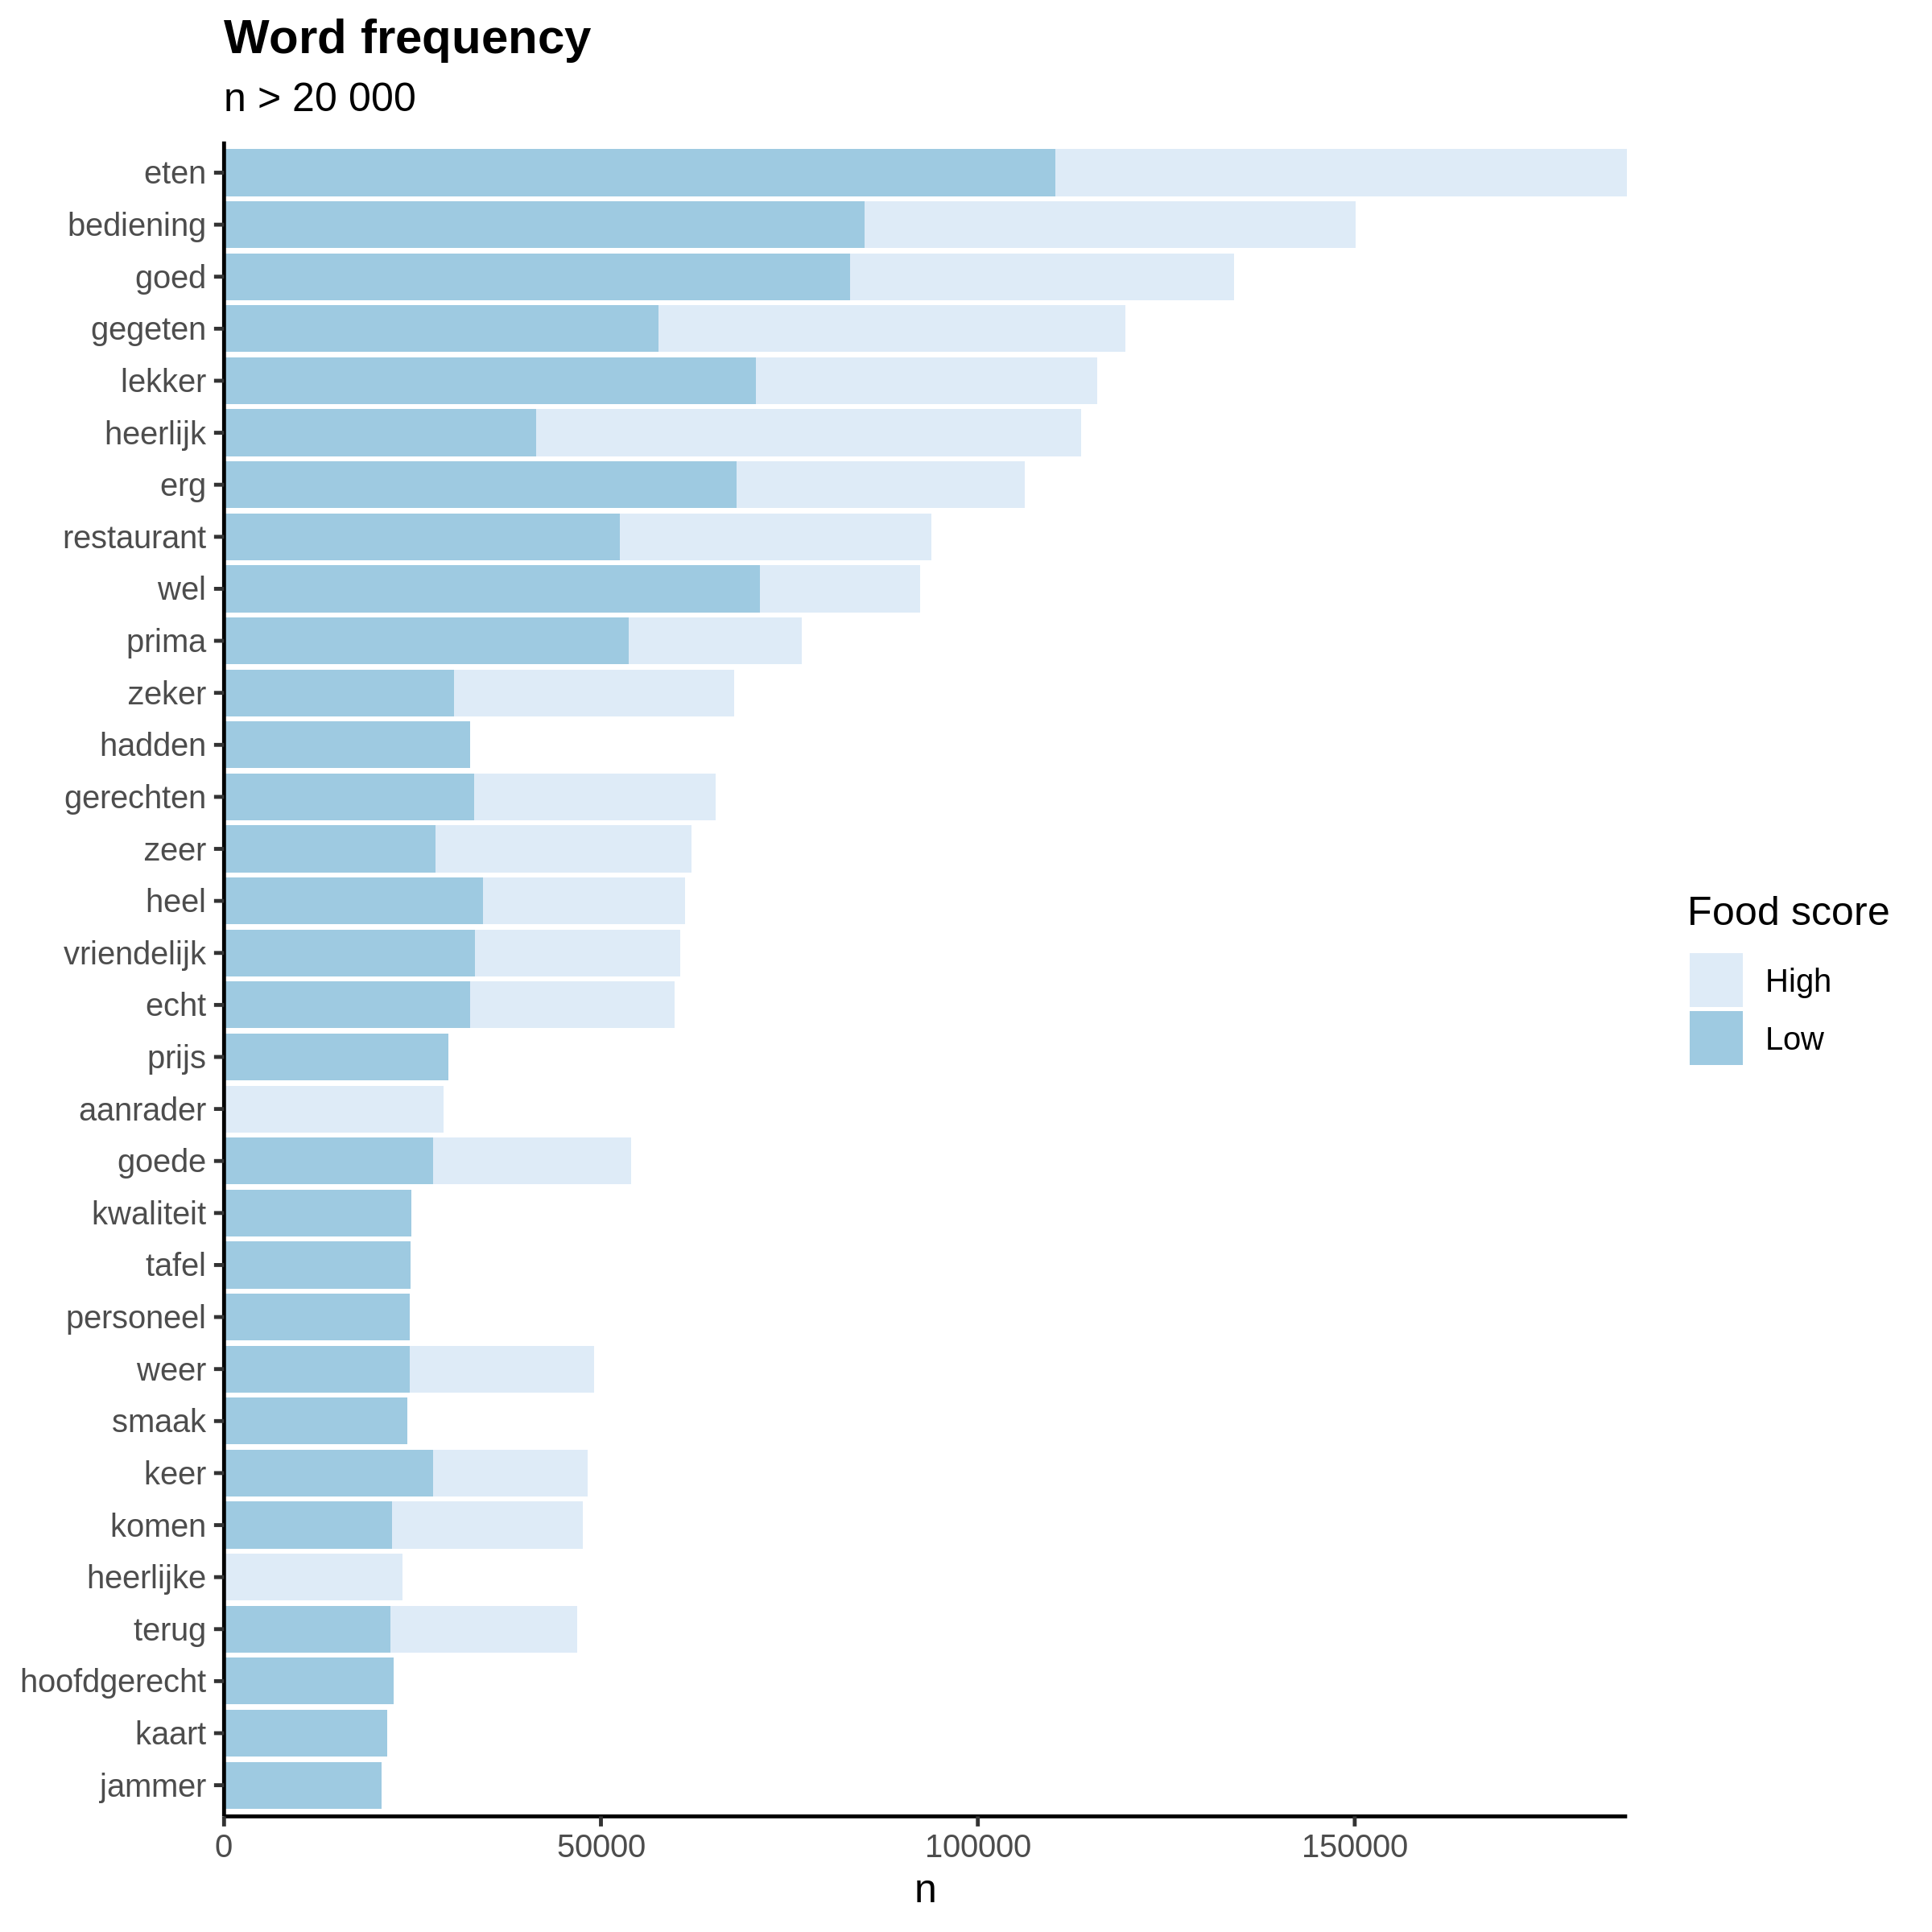

In [8]:
# show it on the plot
tidy_data %>%
  count(score, word, sort = TRUE) %>%
  filter(n > 20000) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n)) +
  geom_col(aes(fill = score)) +
  xlab(NULL) +
  scale_y_continuous(expand = c(0, 0)) +
  coord_flip() +
  theme_classic(base_size = 12) +
  labs(fill= "Food score", title="Word frequency", subtitle="n > 20 000")+
  theme(plot.title = element_text(lineheight=.8, face="bold")) +
  scale_fill_brewer() 

Selecting by n


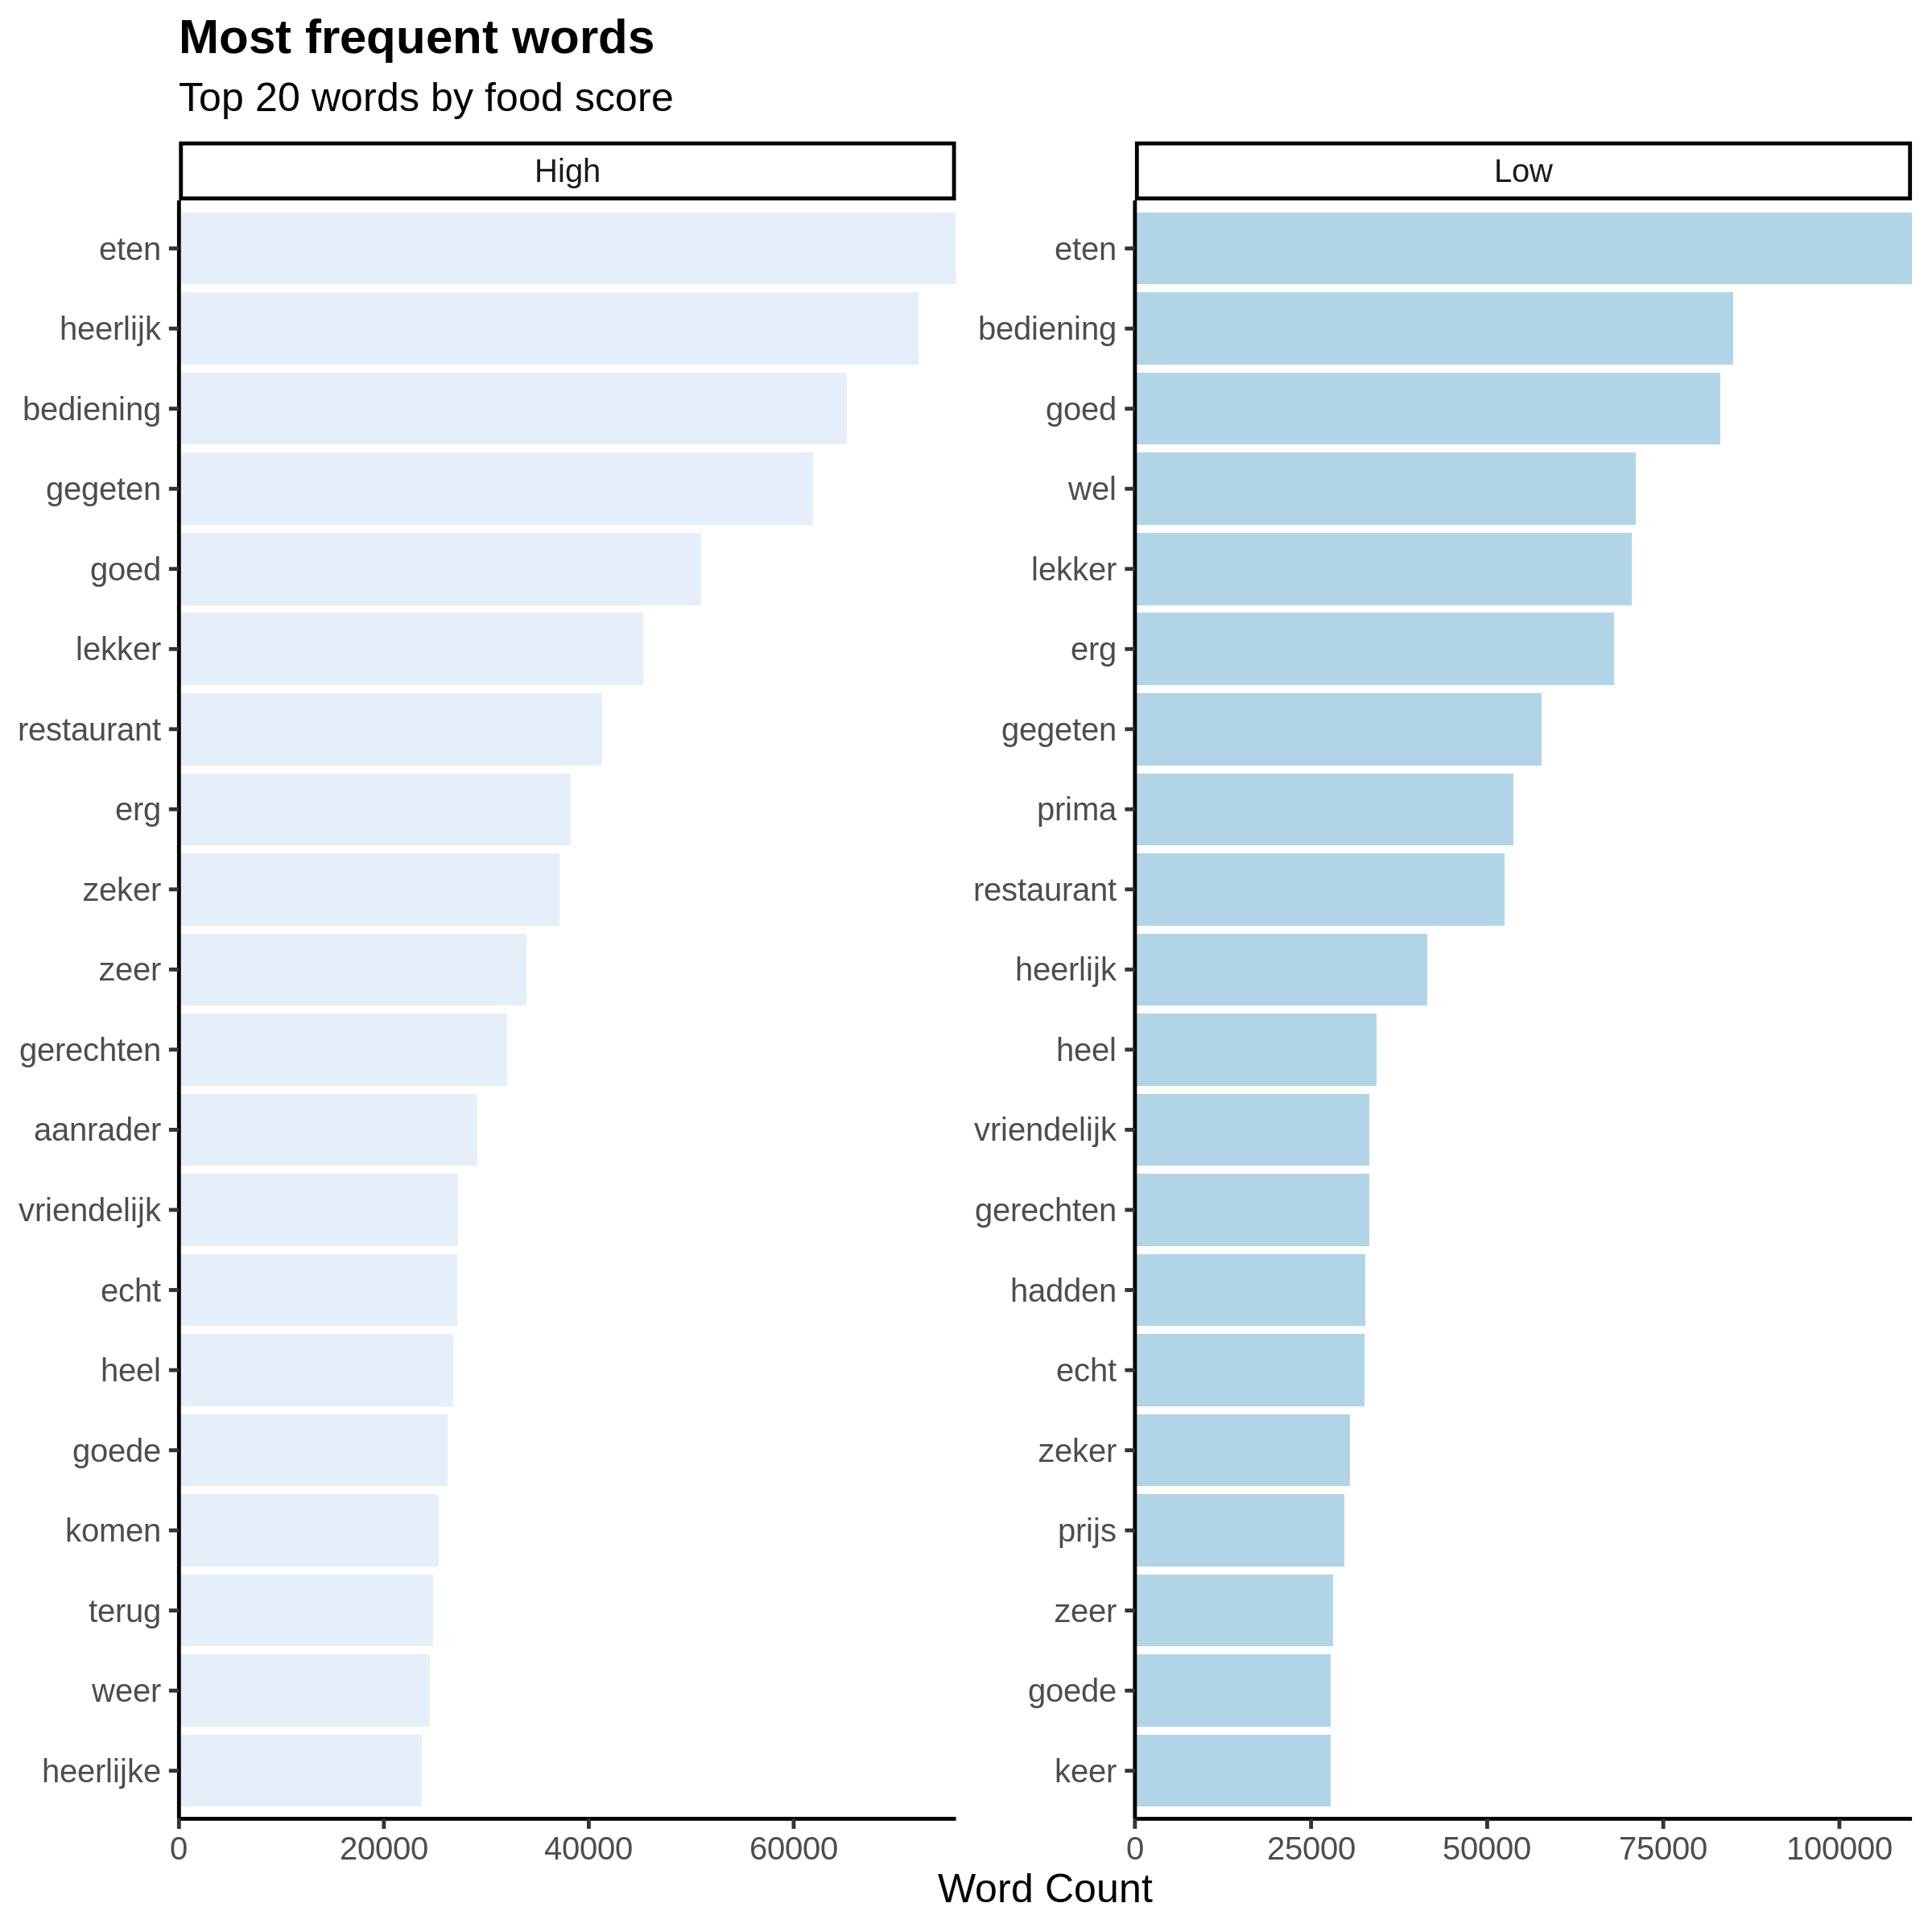

In [9]:
# show it on the plot with separate facets
tidy_data %>%
  count(score, word, sort = TRUE) %>%
  group_by(score) %>%
  top_n(20) %>%
  ungroup() %>%
  ggplot() +
  aes(reorder_within(word, n, score), n, fill = score) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  scale_x_reordered() +
  coord_flip() +
  facet_wrap(~score, scales = "free") +
  scale_y_continuous(expand = c(0, 0)) +
  theme_classic(base_size = 12) +
  labs(fill= "Food score", 
       title="Most frequent words", 
       subtitle="Top 20 words by food score",
       x= NULL, 
       y= "Word Count")+
  theme(plot.title = element_text(lineheight=.8, face="bold")) +
  scale_fill_brewer()

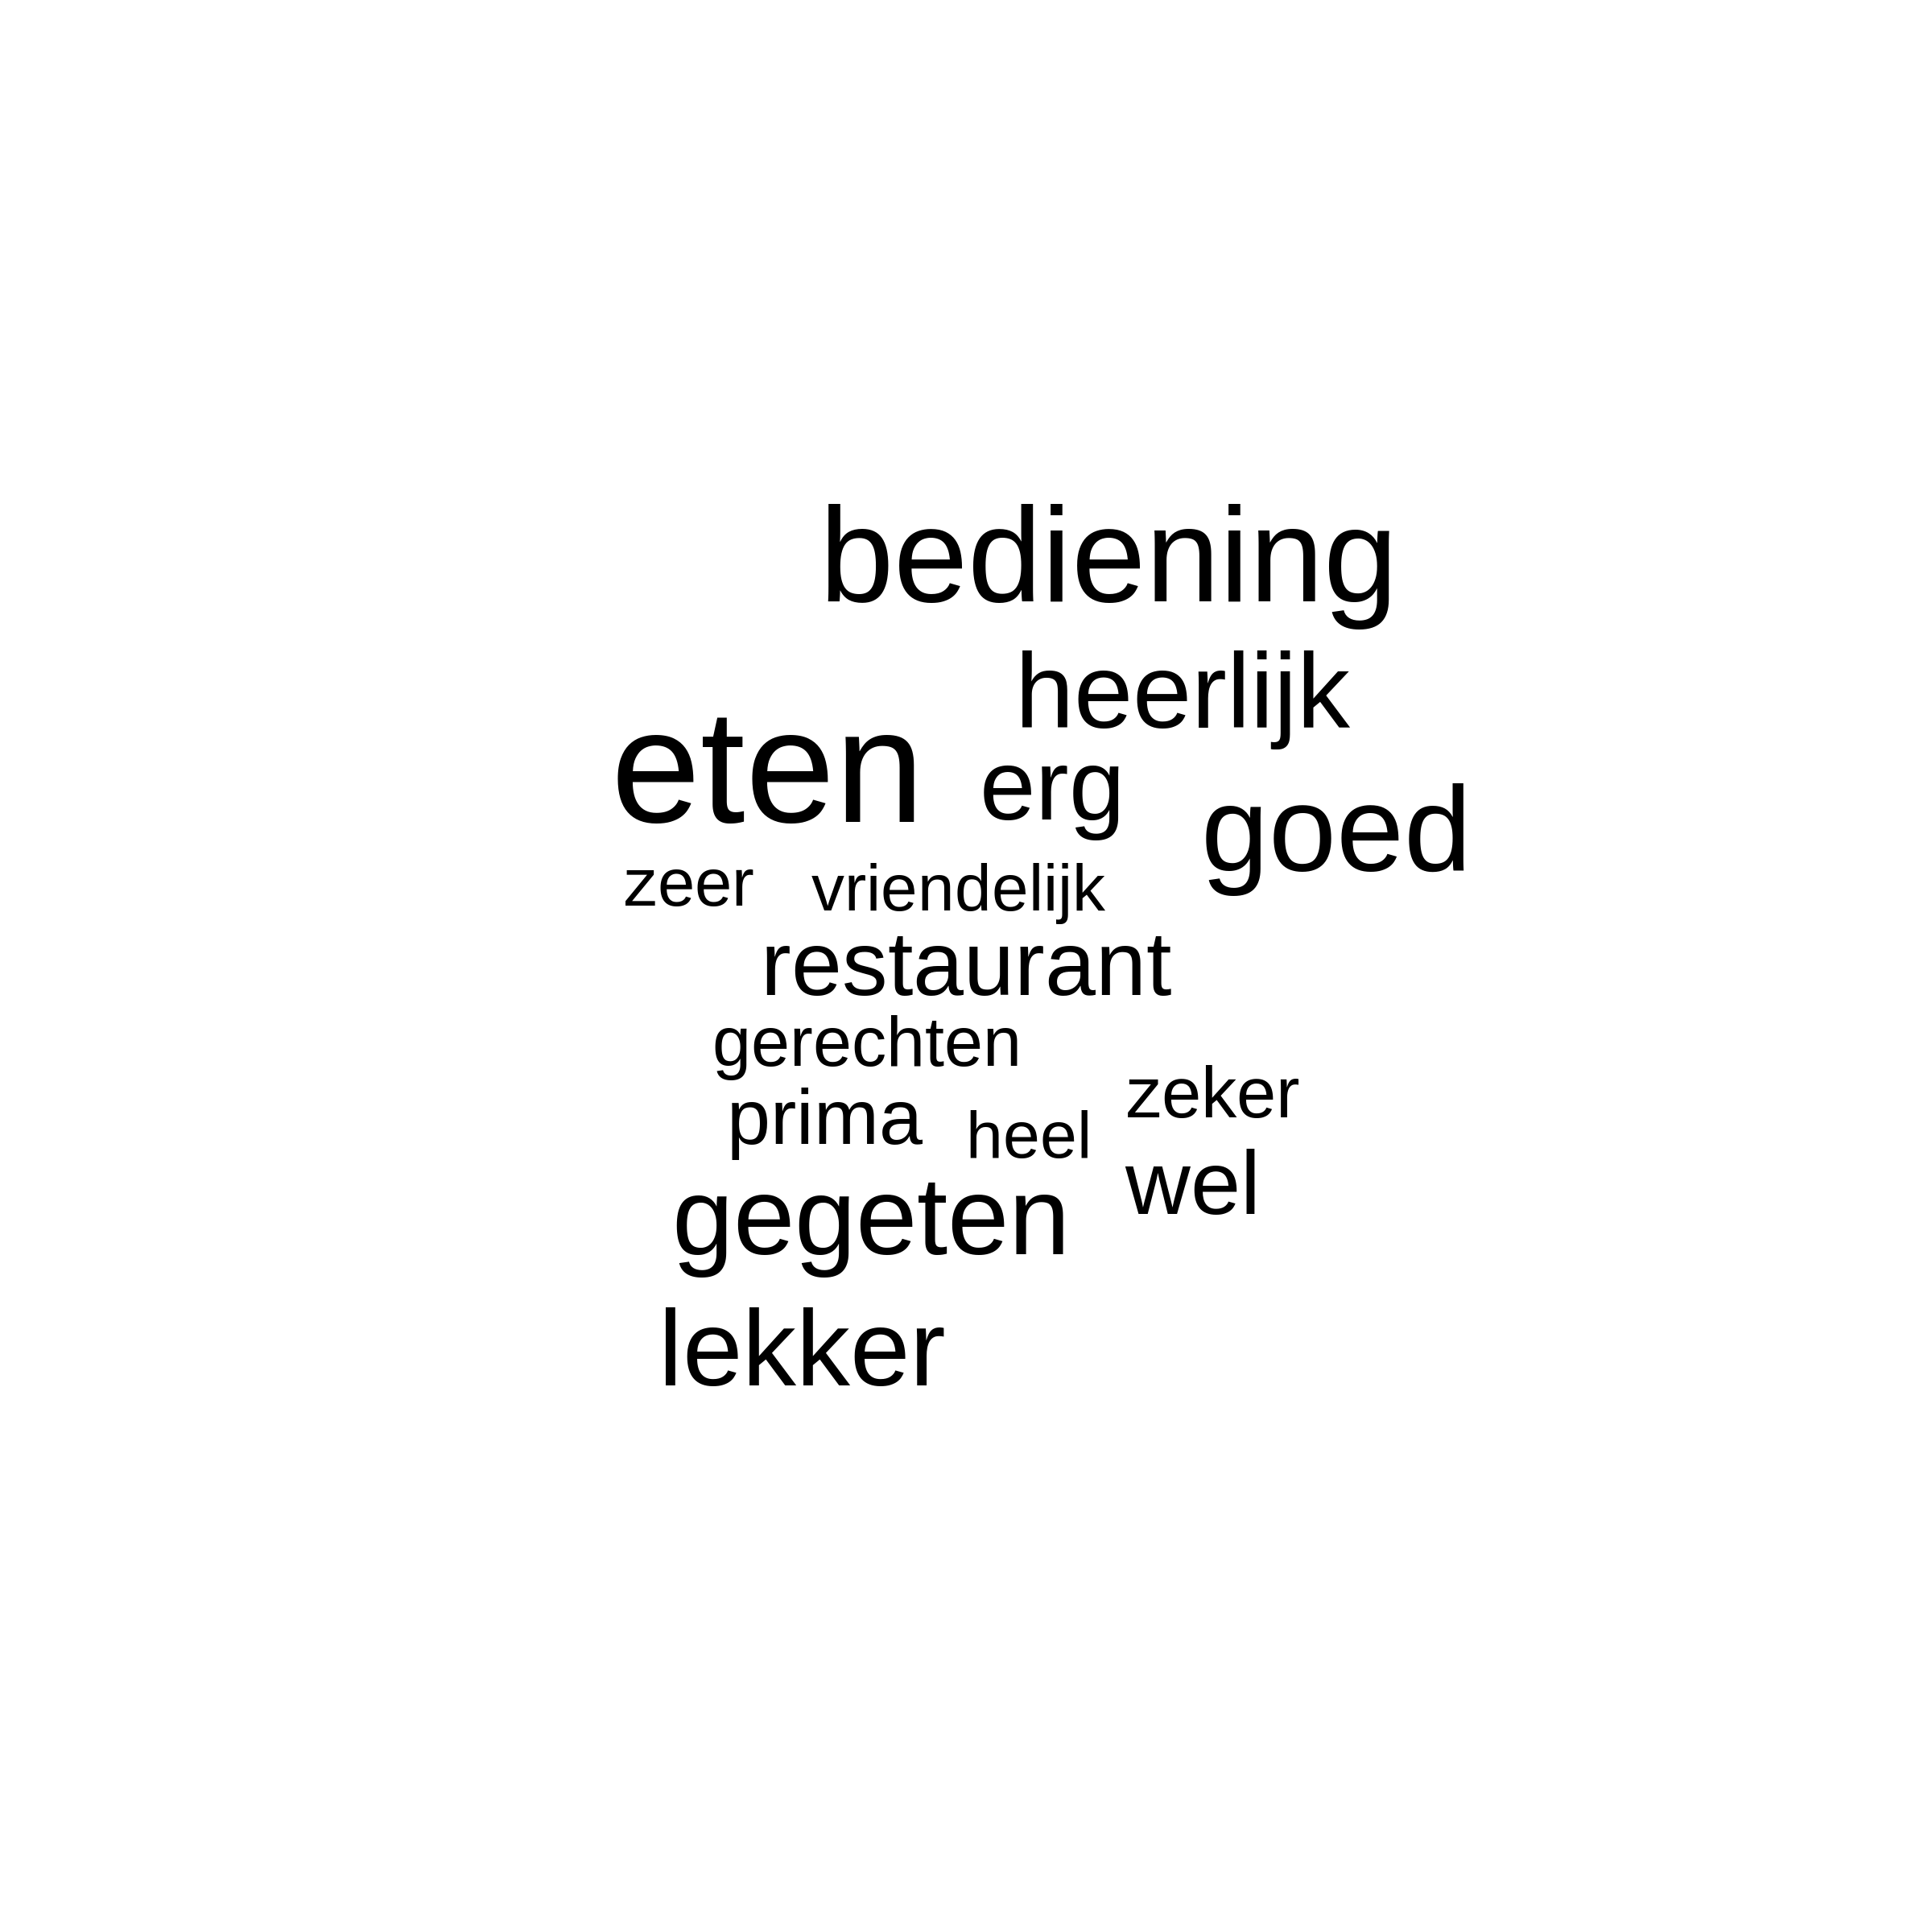

In [10]:
# plot wordcloud
tidy_data %>%
  count(word) %>%
  with(wordcloud(word, n, max.words = 15))

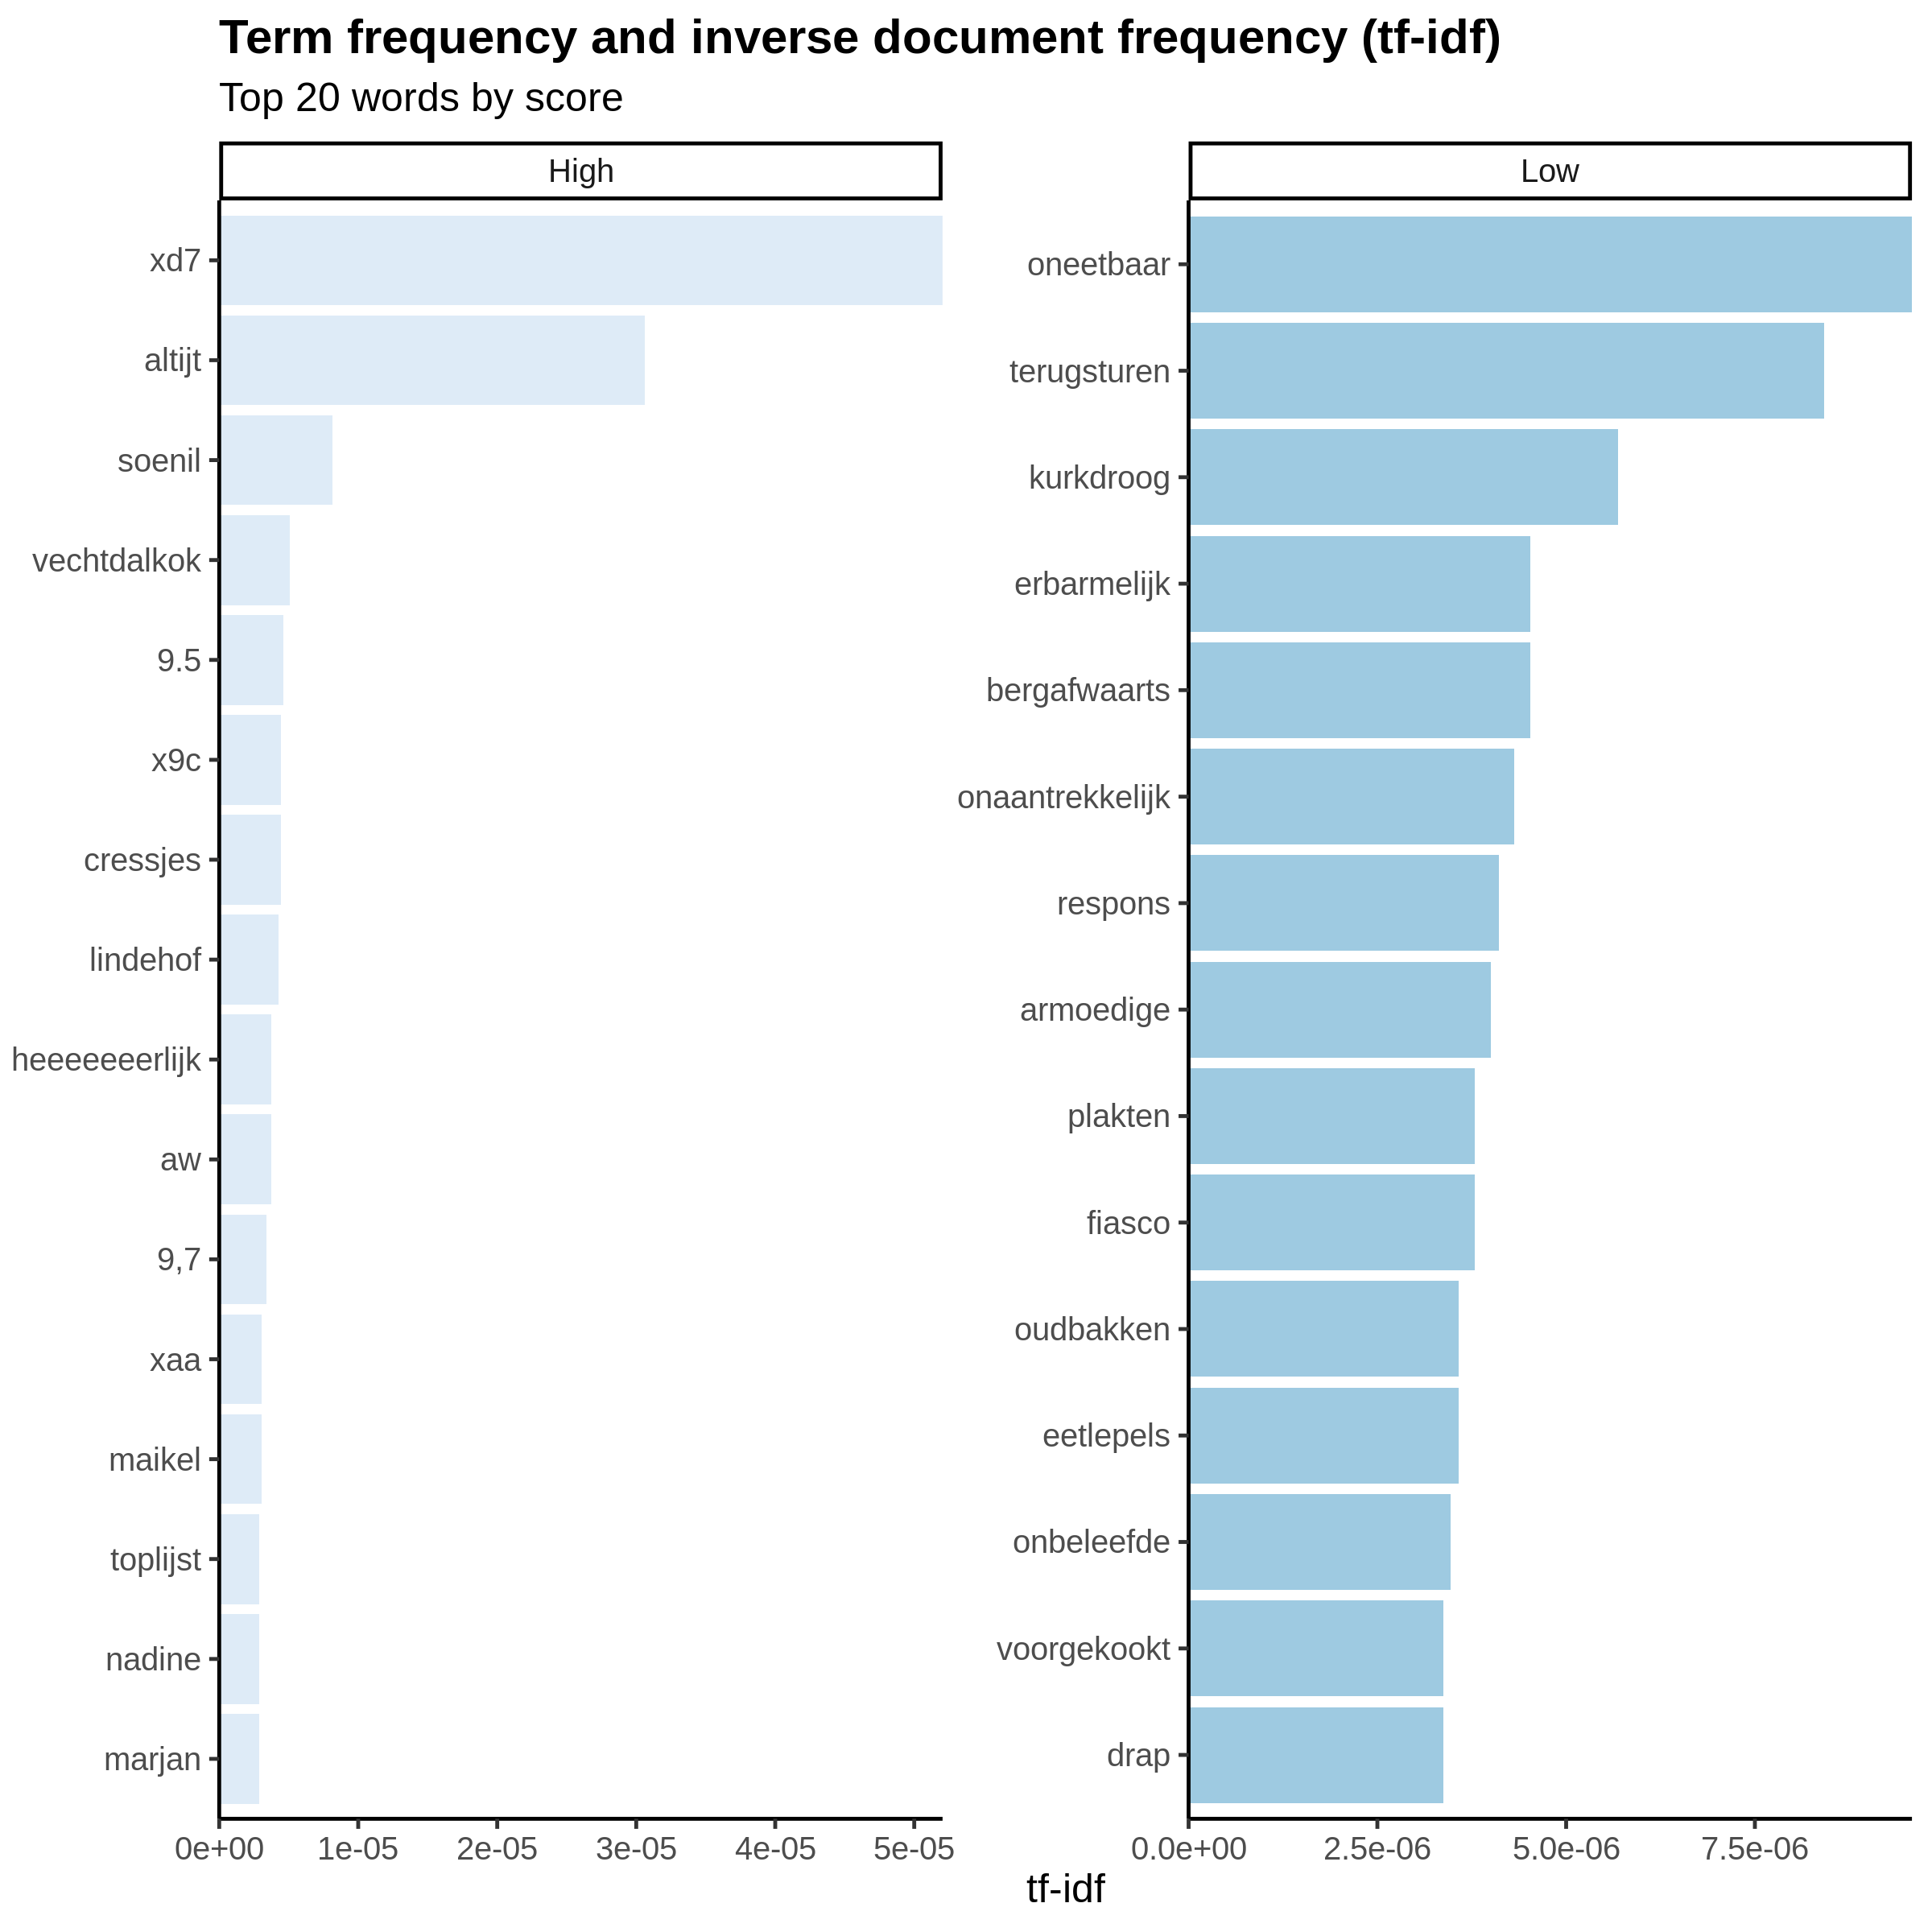

In [11]:
# Term frequency and inverse document frequency (tf-idf)
tidy_data %>%
  count(score, word, sort = TRUE) %>%
  bind_tf_idf(word, score, n) %>%
  mutate(word = fct_reorder(word, tf_idf)) %>%
  mutate(score = factor(score, 
                         levels = c("High",
                                    "Low"))) %>% 
  group_by(score) %>% 
  top_n(15, tf_idf) %>% 
  ungroup() %>%
  mutate(word = reorder(word, tf_idf)) %>%
  ggplot(aes(word, tf_idf, fill = score)) +
  scale_y_continuous(expand = c(0, 0)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~score, ncol = 2, scales = "free") +
  coord_flip() +
  theme_classic(base_size = 12) +
  labs(fill= "Food score", 
       title="Term frequency and inverse document frequency (tf-idf)", 
       subtitle="Top 20 words by score",
       x= NULL, 
       y= "tf-idf") +
  theme(plot.title = element_text(lineheight=.8, face="bold")) +
  scale_fill_brewer() 

In [12]:
# Tokenizing by n-gram reviews of Leiden resaturants
bigrams <- reviews %>% 
  filter(str_detect(address , 'Leiden')) %>% 
  select(restoId, reviewerId, reviewText) %>%
  unnest_tokens(bigram, reviewText, token = "ngrams", n = 2)
# Most frequent bigrams
bigrams %>% 
  count(bigram, sort = TRUE) %>% 
  head()

bigram,n
<chr>,<int>
het eten,858
van de,833
de bediening,747
en de,706
in de,588
met een,577


In [13]:
# Least frequent bigrams
bigrams %>% 
  count(bigram, sort = TRUE) %>% 
  tail()

bigram,n
<chr>,<int>
zwijn was,1
zwlfs een,1
zwoele avond,1
zwoele zomeravonden,1
zwoerd ik,1
zwom in,1


In [14]:
# seperate words
bigrams_separated <- bigrams %>%
  separate(bigram, c("word1", "word2"), sep = " ")

# filter stop words and NA
bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word) %>% 
  filter(!is.na(word1))

# new bigram counts:
bigram_counts <- bigrams_filtered %>% 
  count(word1, word2, sort = TRUE)
  
# Most frequent seperated bigrams  
bigram_counts  %>% head()

word1,word2,n
<chr>,<chr>,<int>
heerlijk,gegeten,514
erg,lekker,264
vriendelijke,bediening,235
prijs,kwaliteit,210
lekker,gegeten,200
lekker,eten,164


In [15]:
# check terms going together with 'vis'
bigrams_filtered %>%
  filter(word2 == "vis") %>%
  count(word1, sort = TRUE) %>%
  head()

word1,n
<chr>,<int>
vlees,16
soorten,10
stukje,4
verse,3
zowel,3
eten,2


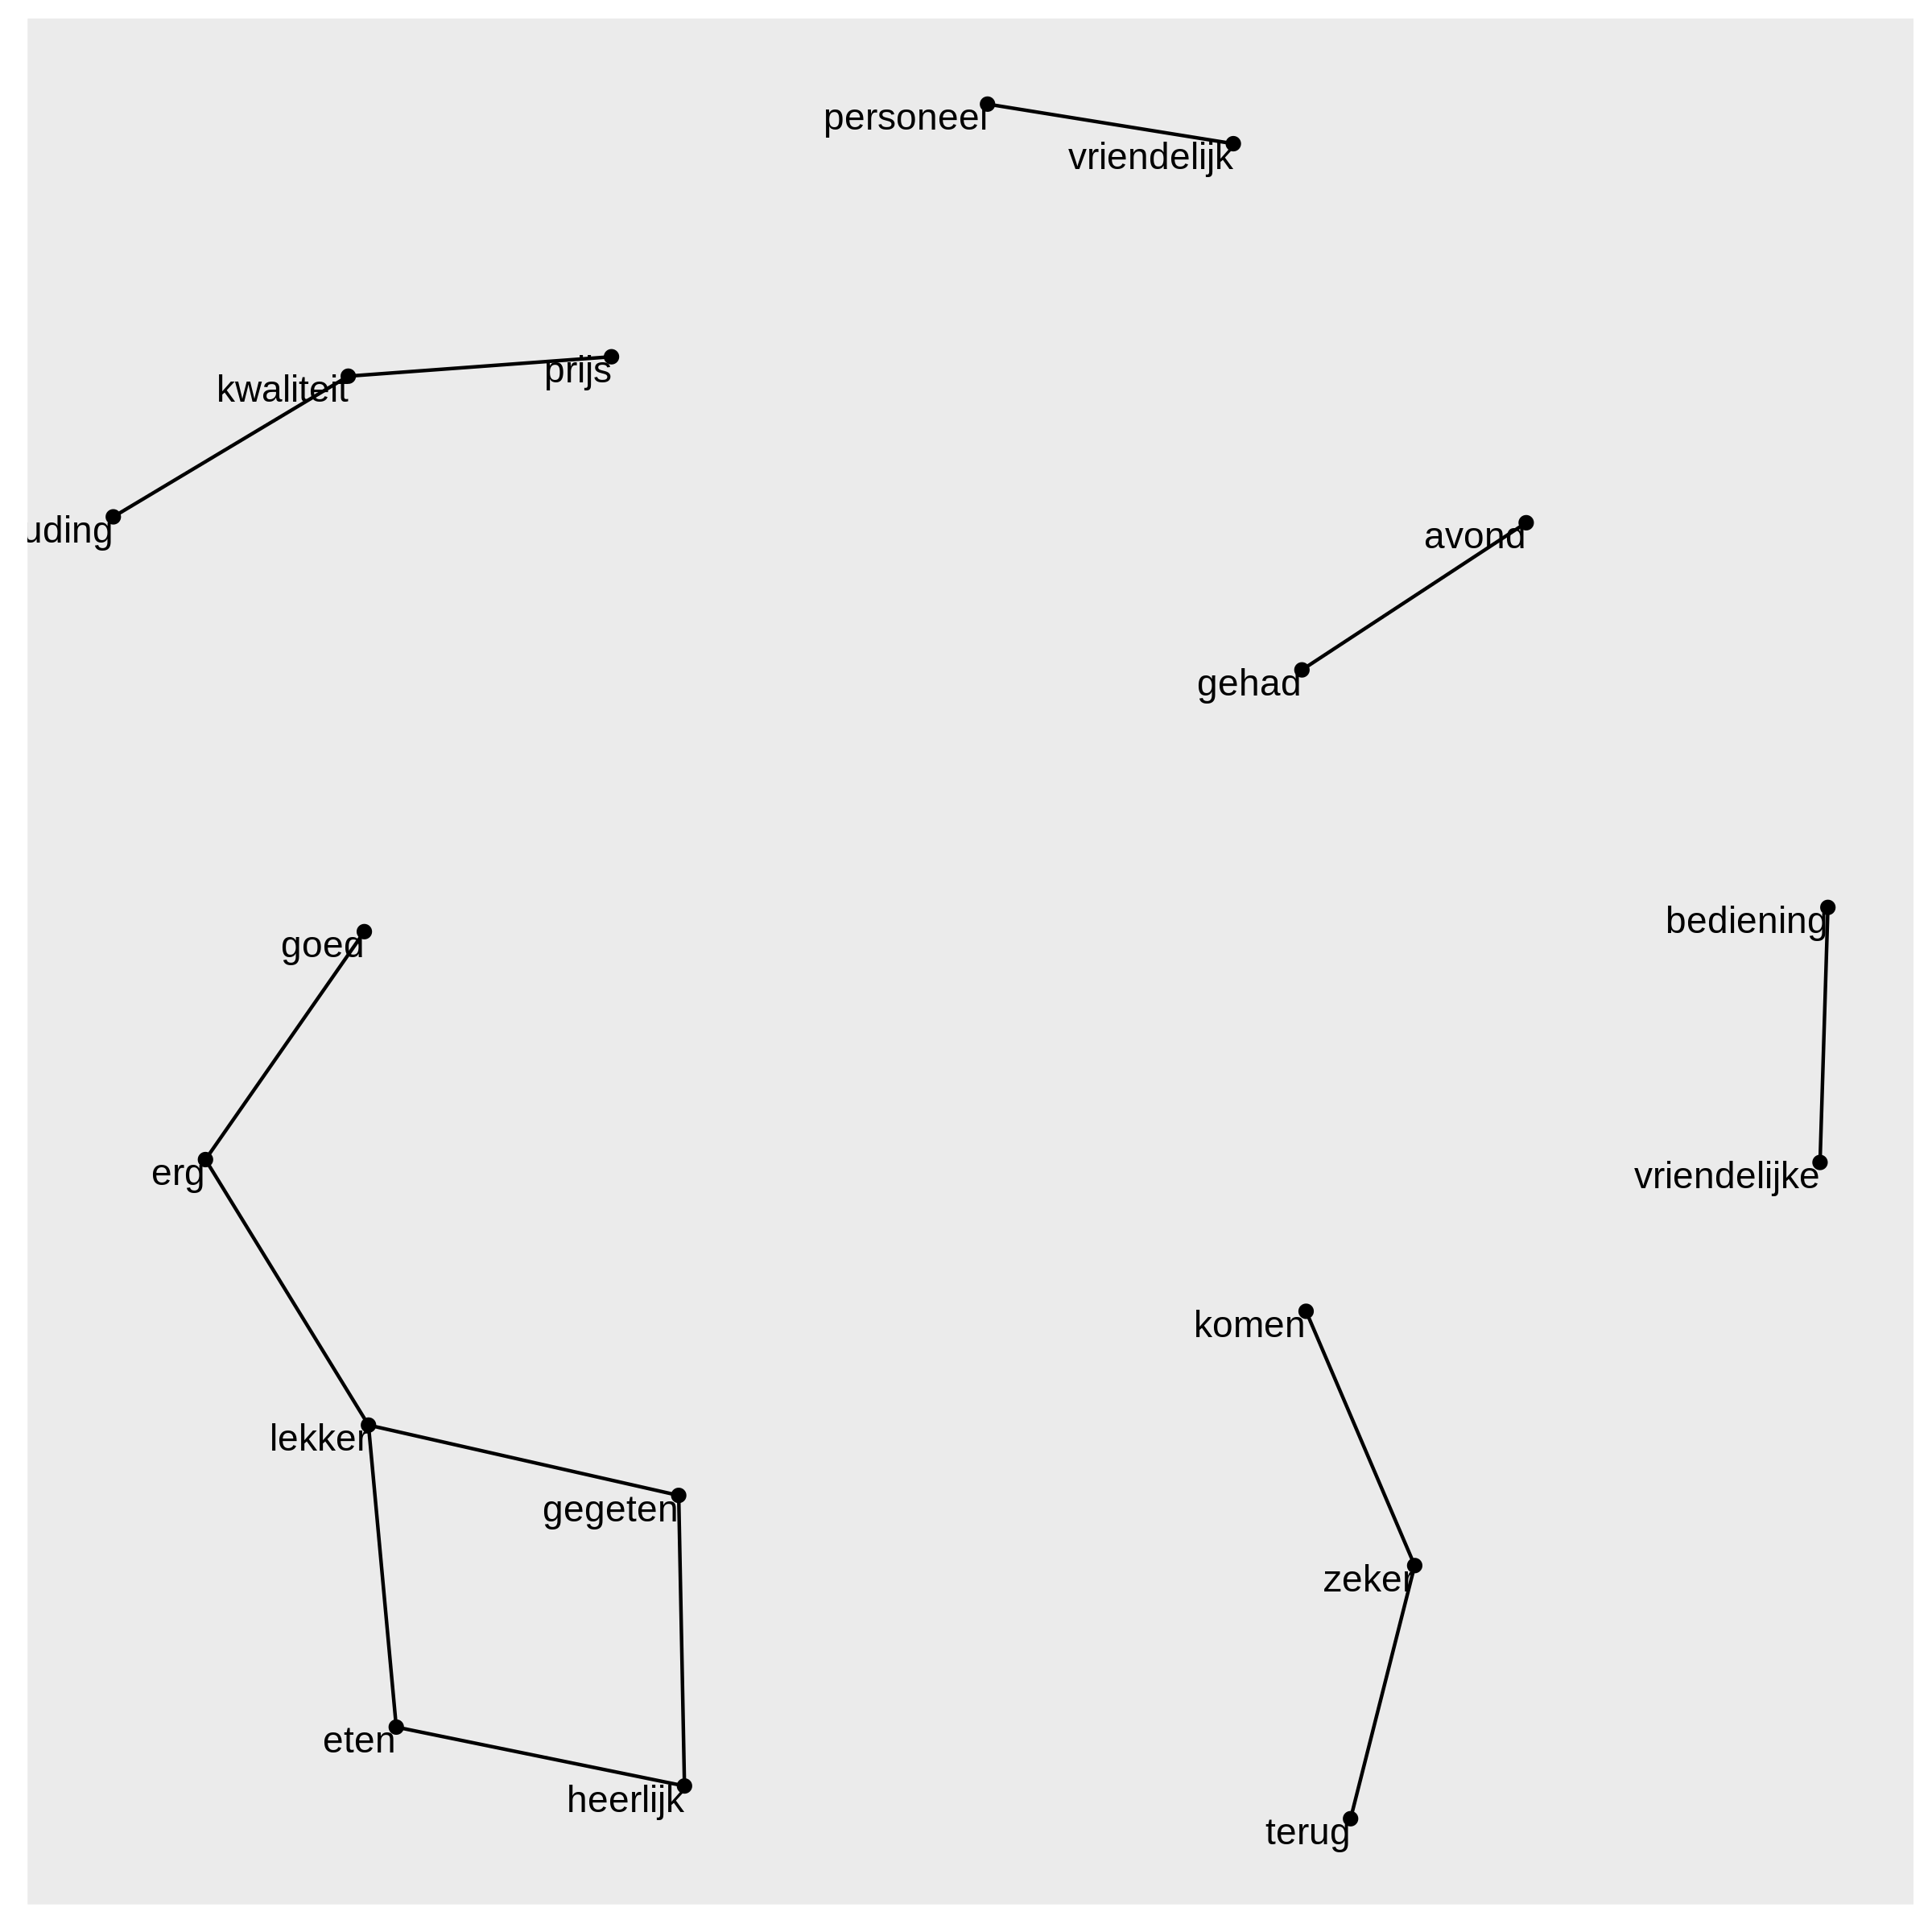

In [16]:
# create and plot graph object
bigram_counts %>%
  filter(n > 100) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

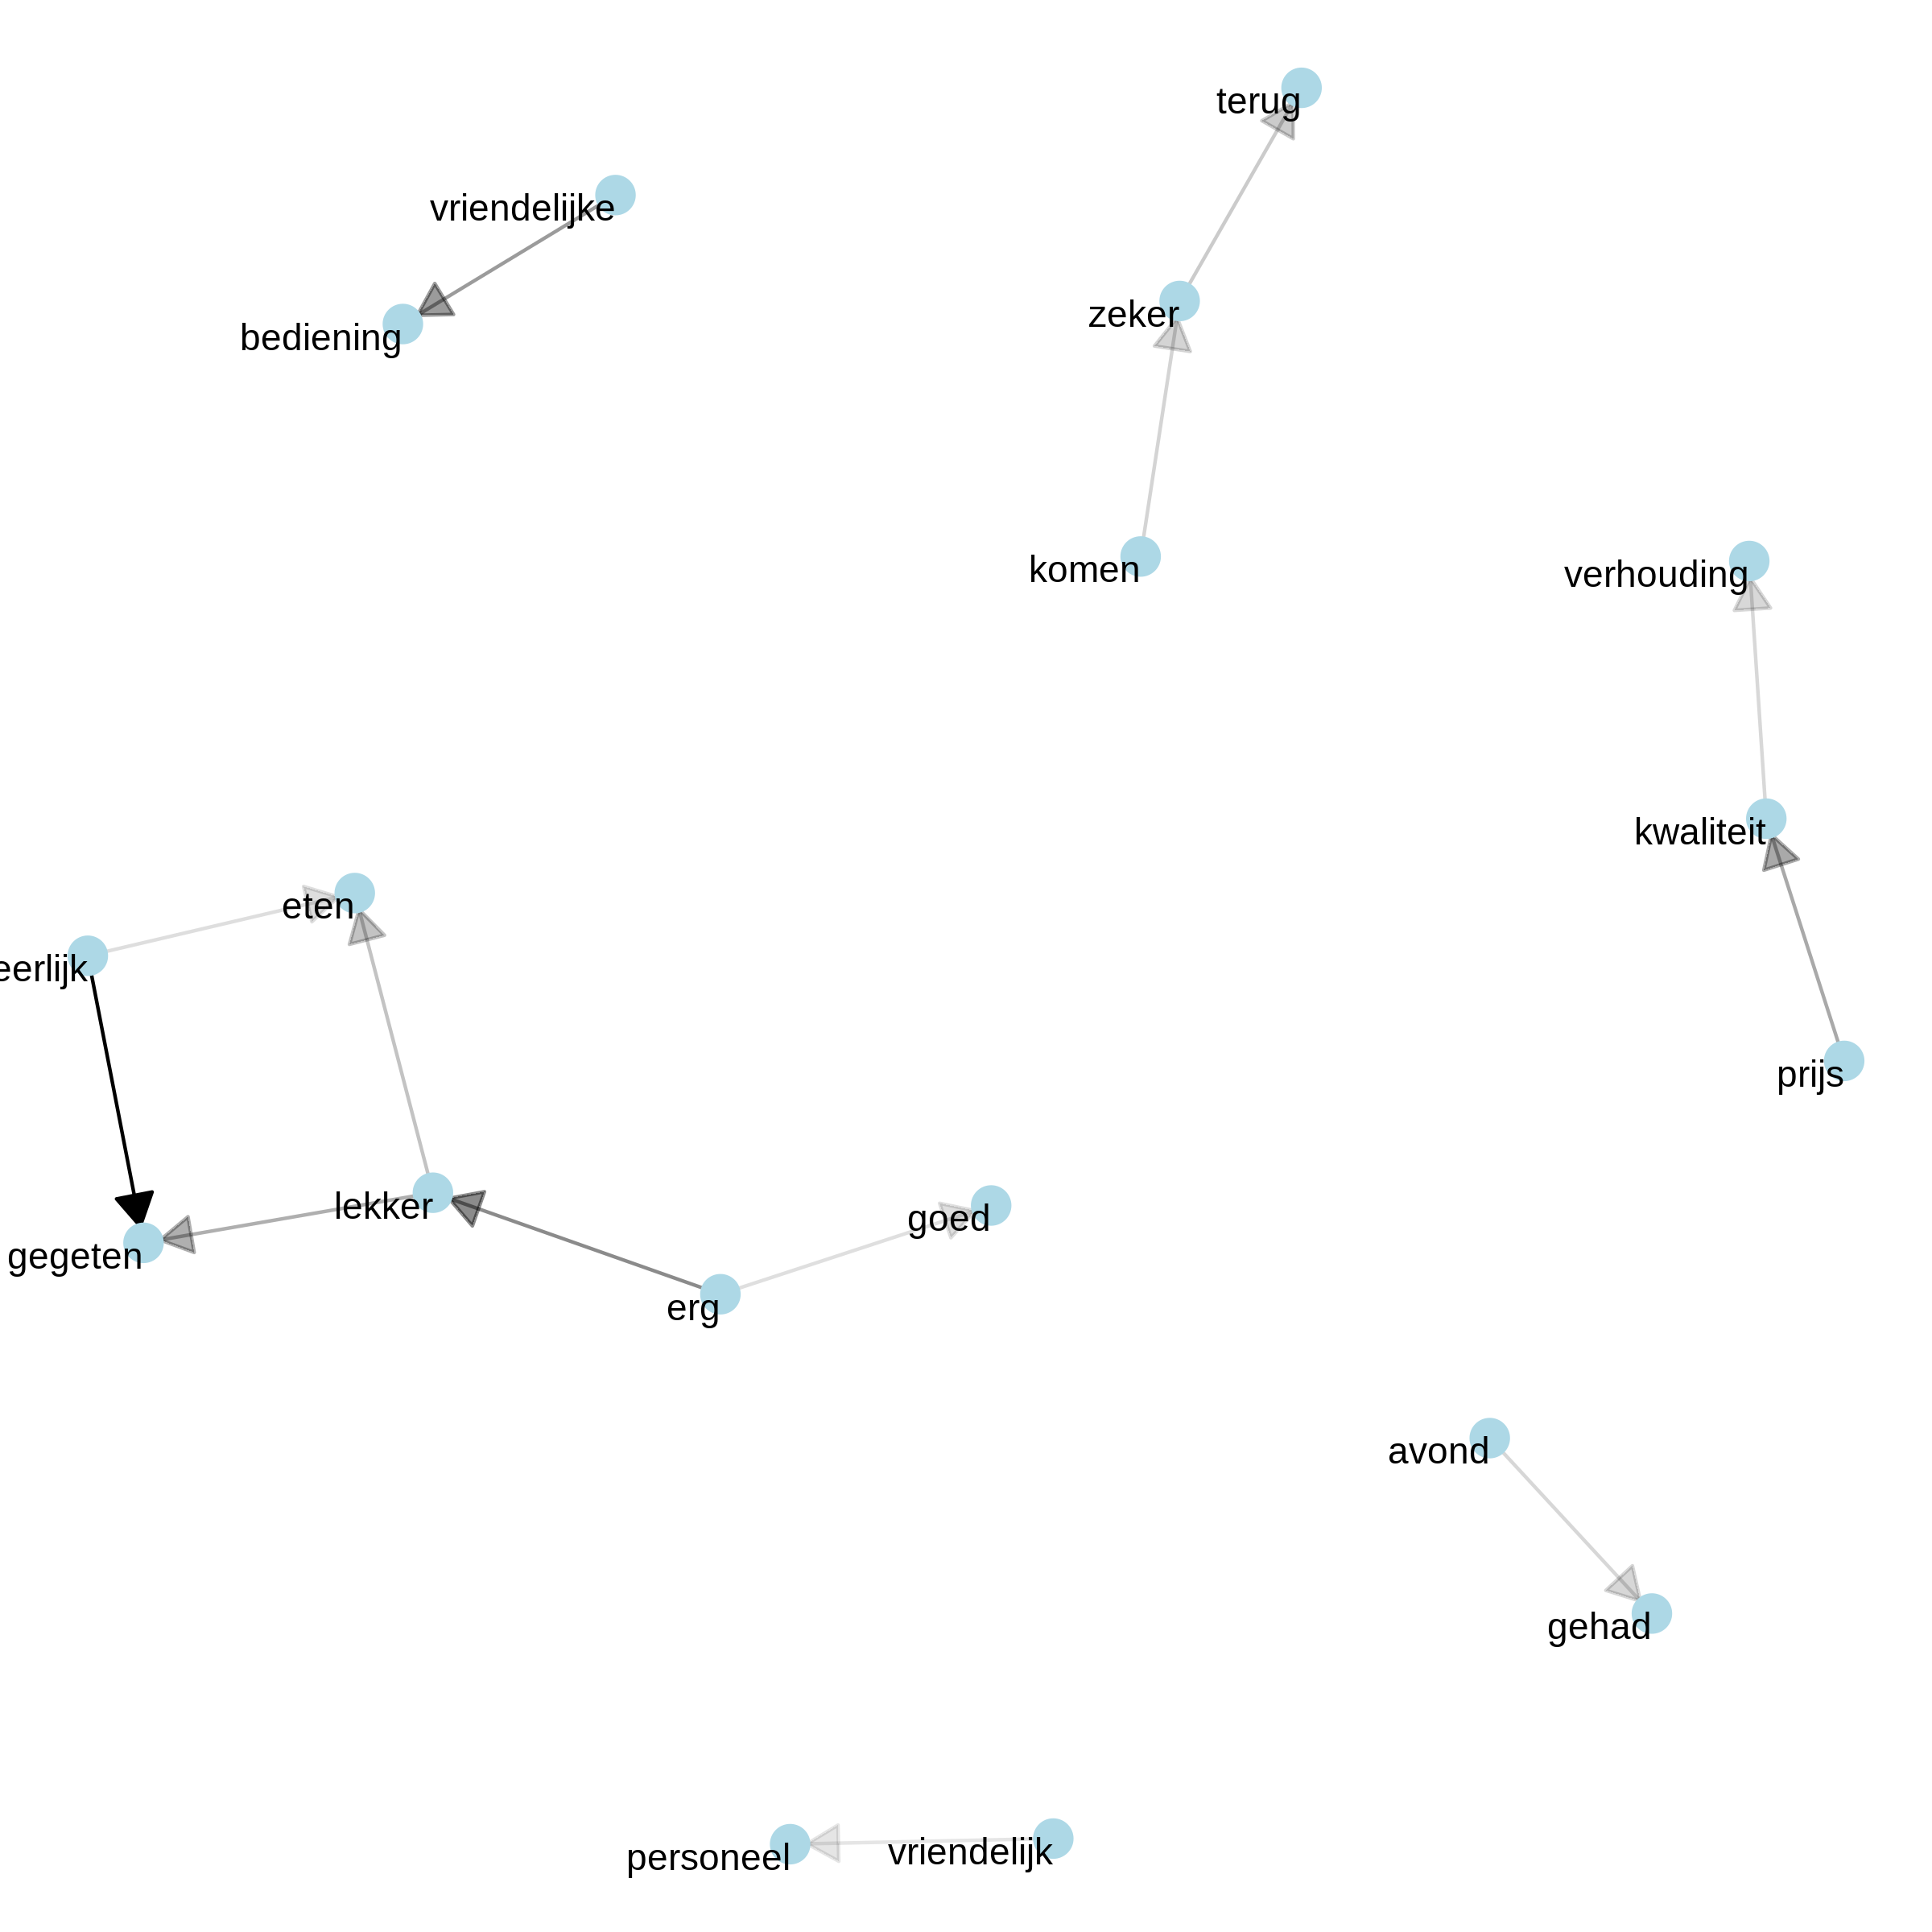

In [17]:
# the same more fancy
bigram_counts %>%
  filter(n > 100) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = grid::arrow(type = "closed", length = unit(.15, "inches")),
                 end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()


# Classification with logistic regression

In [18]:
# split the data
reviews <- read_csv("/tmp/reviews.csv.gz") %>%
  filter(str_detect(address , 'Leiden')) %>% 
#  filter(reviewDate > as.POSIXct('2017-12-24 23:00:00')) %>%
  mutate(document = paste(restoId, review_id, sep = "_")) %>%
  mutate(target = if_else(reviewScoreFood > 8, "High", "Low")) #7

split <- reviews %>%
  select(document) %>%
  initial_split(prop = 3/4)

train_data <- training(split)
test_data <- testing(split)
reviews %>% dim()
train_data %>% dim()

Rows: 339524 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (8): restoName, tags, address, valueForPriceScore, noiseLevelScore, wa...
dbl  (15): restoId, scoreTotal, avgPrice, numReviews, scoreFood, scoreServic...
dttm  (1): reviewDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 4285   26

[1] 3213    1

In [19]:
# tokenize the data
tidy_data <- reviews %>%
  select(document, reviewText) %>% 
  drop_na() %>% distinct() %>%
  unnest_tokens(word, reviewText)
tidy_data %>% head() 

document,word
<chr>,<chr>
243427_1,beste
243427_1,mensen
243427_1,van
243427_1,omonia
243427_1,als
243427_1,jullie


In [20]:
# create sparse matrix for training with predictors
sparse_words <- tidy_data %>%
  count(document, word) %>%
  inner_join(train_data) %>%
  cast_sparse(document, word, n)
sparse_words %>% dim()  

Joining, by = "document"


[1]  3213 11205

In [21]:
# create response variable
is_good <- sparse_words %>% 
  rownames() %>%
  as.tibble() %>%
  rename(document = value) %>%
  left_join(reviews  %>% select(document, target)) %>% 
  mutate(target = ifelse(target == "High", "TRUE", "FALSE")) %>% 
  select(target) %>% pull()
is_good %>% table()

Warning message:
“`as.tibble()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”
Joining, by = "document"


.
FALSE  TRUE 
 1867  1346 

In [22]:
# train model with 8 cores
registerDoMC(cores = 8)
model <- cv.glmnet(sparse_words, 
                   is_good,
                   family = "binomial",
                   parallel = TRUE, 
                   keep = TRUE)
#plot(model)
#plot(model$glmnet.fit)                   

In [23]:
# get coefficients
coefs <- model$glmnet.fit %>%
  tidy() %>%
  filter(lambda == model$lambda.1se)
coefs %>% head()

term,step,estimate,lambda,dev.ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),42,-0.263416127,0.01857132,0.2012291
heerlijk,42,0.587191915,0.01857132,0.2012291
veel,42,-0.004368853,0.01857132,0.2012291
iets,42,-0.232074360,0.01857132,0.2012291
maar,42,-0.108464318,0.01857132,0.2012291
meer,42,-0.193138583,0.01857132,0.2012291


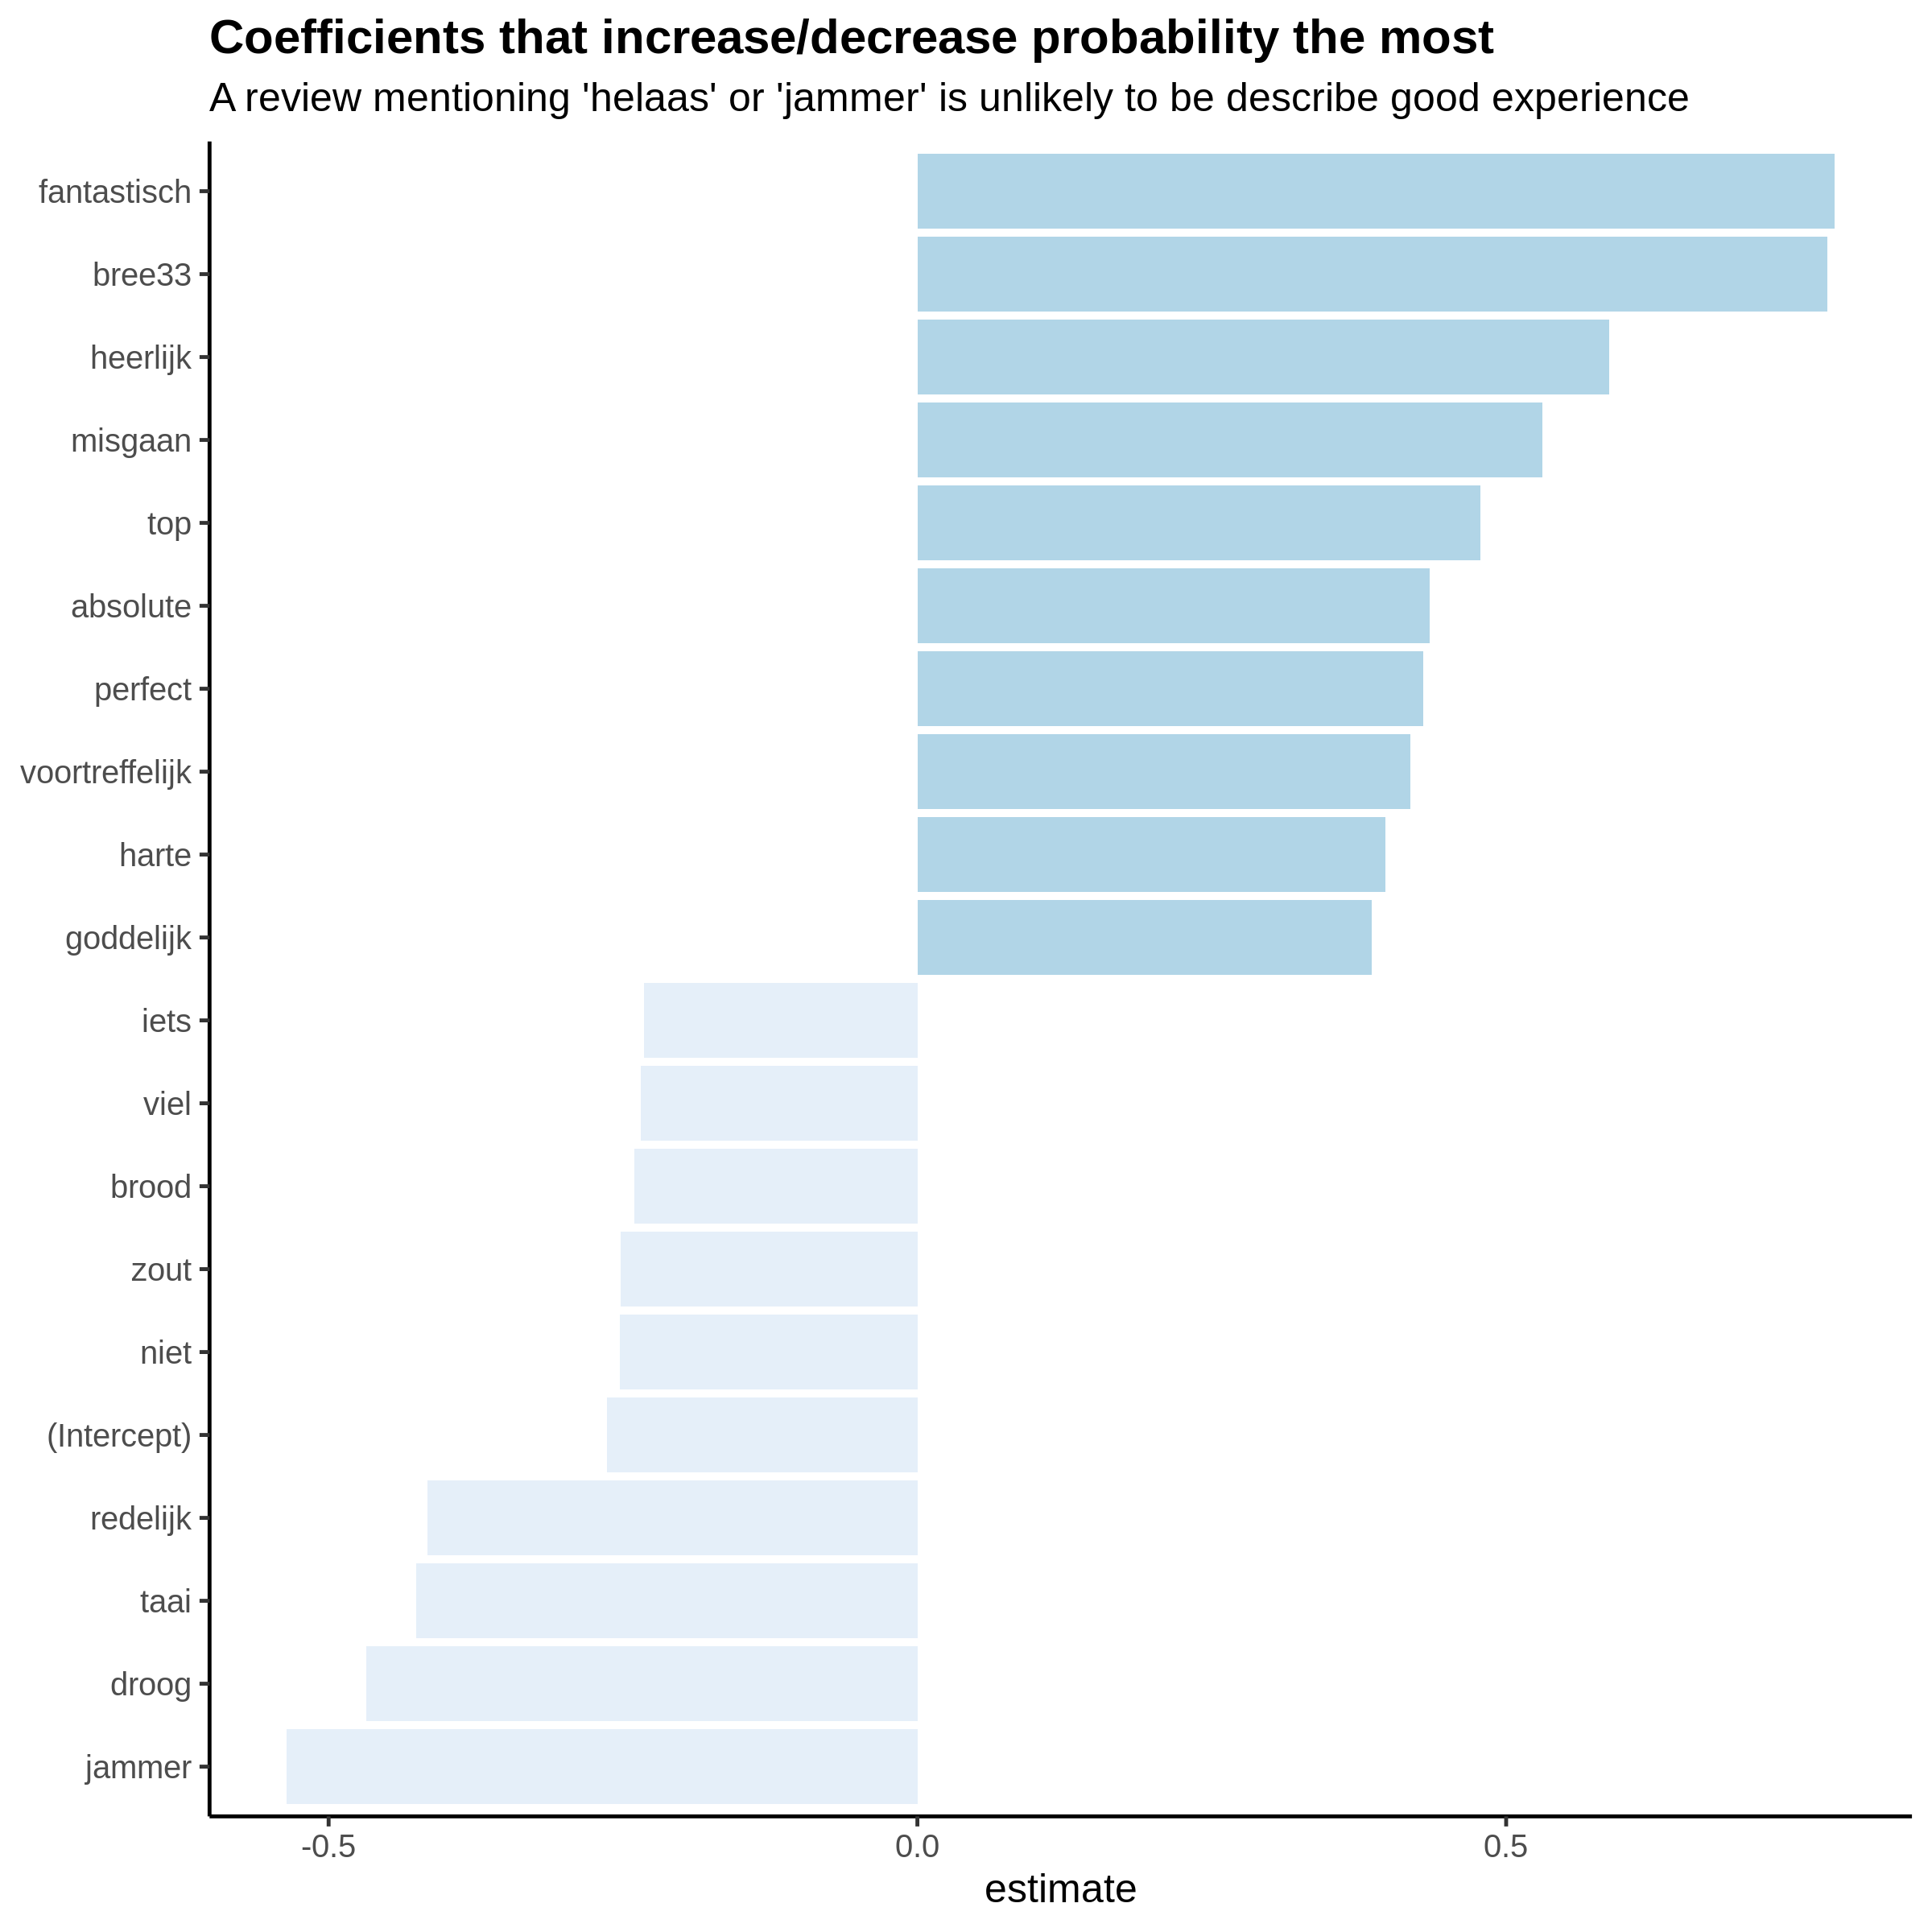

In [24]:
# plot them
coefs %>%
  group_by(estimate > 0) %>%
  top_n(10, abs(estimate)) %>%
  ungroup() %>%
  ggplot(aes(fct_reorder(term, estimate), estimate, fill = estimate > 0)) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  coord_flip() +
  labs(
    x = NULL,
    title = "Coefficients that increase/decrease probability the most",
    subtitle = "A review mentioning 'helaas' or 'jammer' is unlikely to be describe good experience"
  ) +
  theme_classic(base_size = 12) +
  theme(plot.title = element_text(lineheight=.8, face="bold")) +
  scale_fill_brewer()  

In [25]:
# make predictions
intercept <- coefs %>%
  filter(term == "(Intercept)") %>%
  pull(estimate)

classifications <- tidy_data %>%
  inner_join(test_data) %>%
  inner_join(coefs, by = c("word" = "term")) %>%
  group_by(document) %>%
  summarize(score = sum(estimate)) %>%
  mutate(probability = plogis(intercept + score))

 classifications %>% head() 

Joining, by = "document"


document,score,probability
<chr>,<dbl>,<dbl>
221137_11,0.8755082,0.6484179
221137_13,0.4052901,0.5354091
221137_17,-0.5558451,0.3059205
221137_9,0.5871919,0.5802442
221215_13,-0.4916125,0.3197266
221215_19,-0.4895857,0.3201676


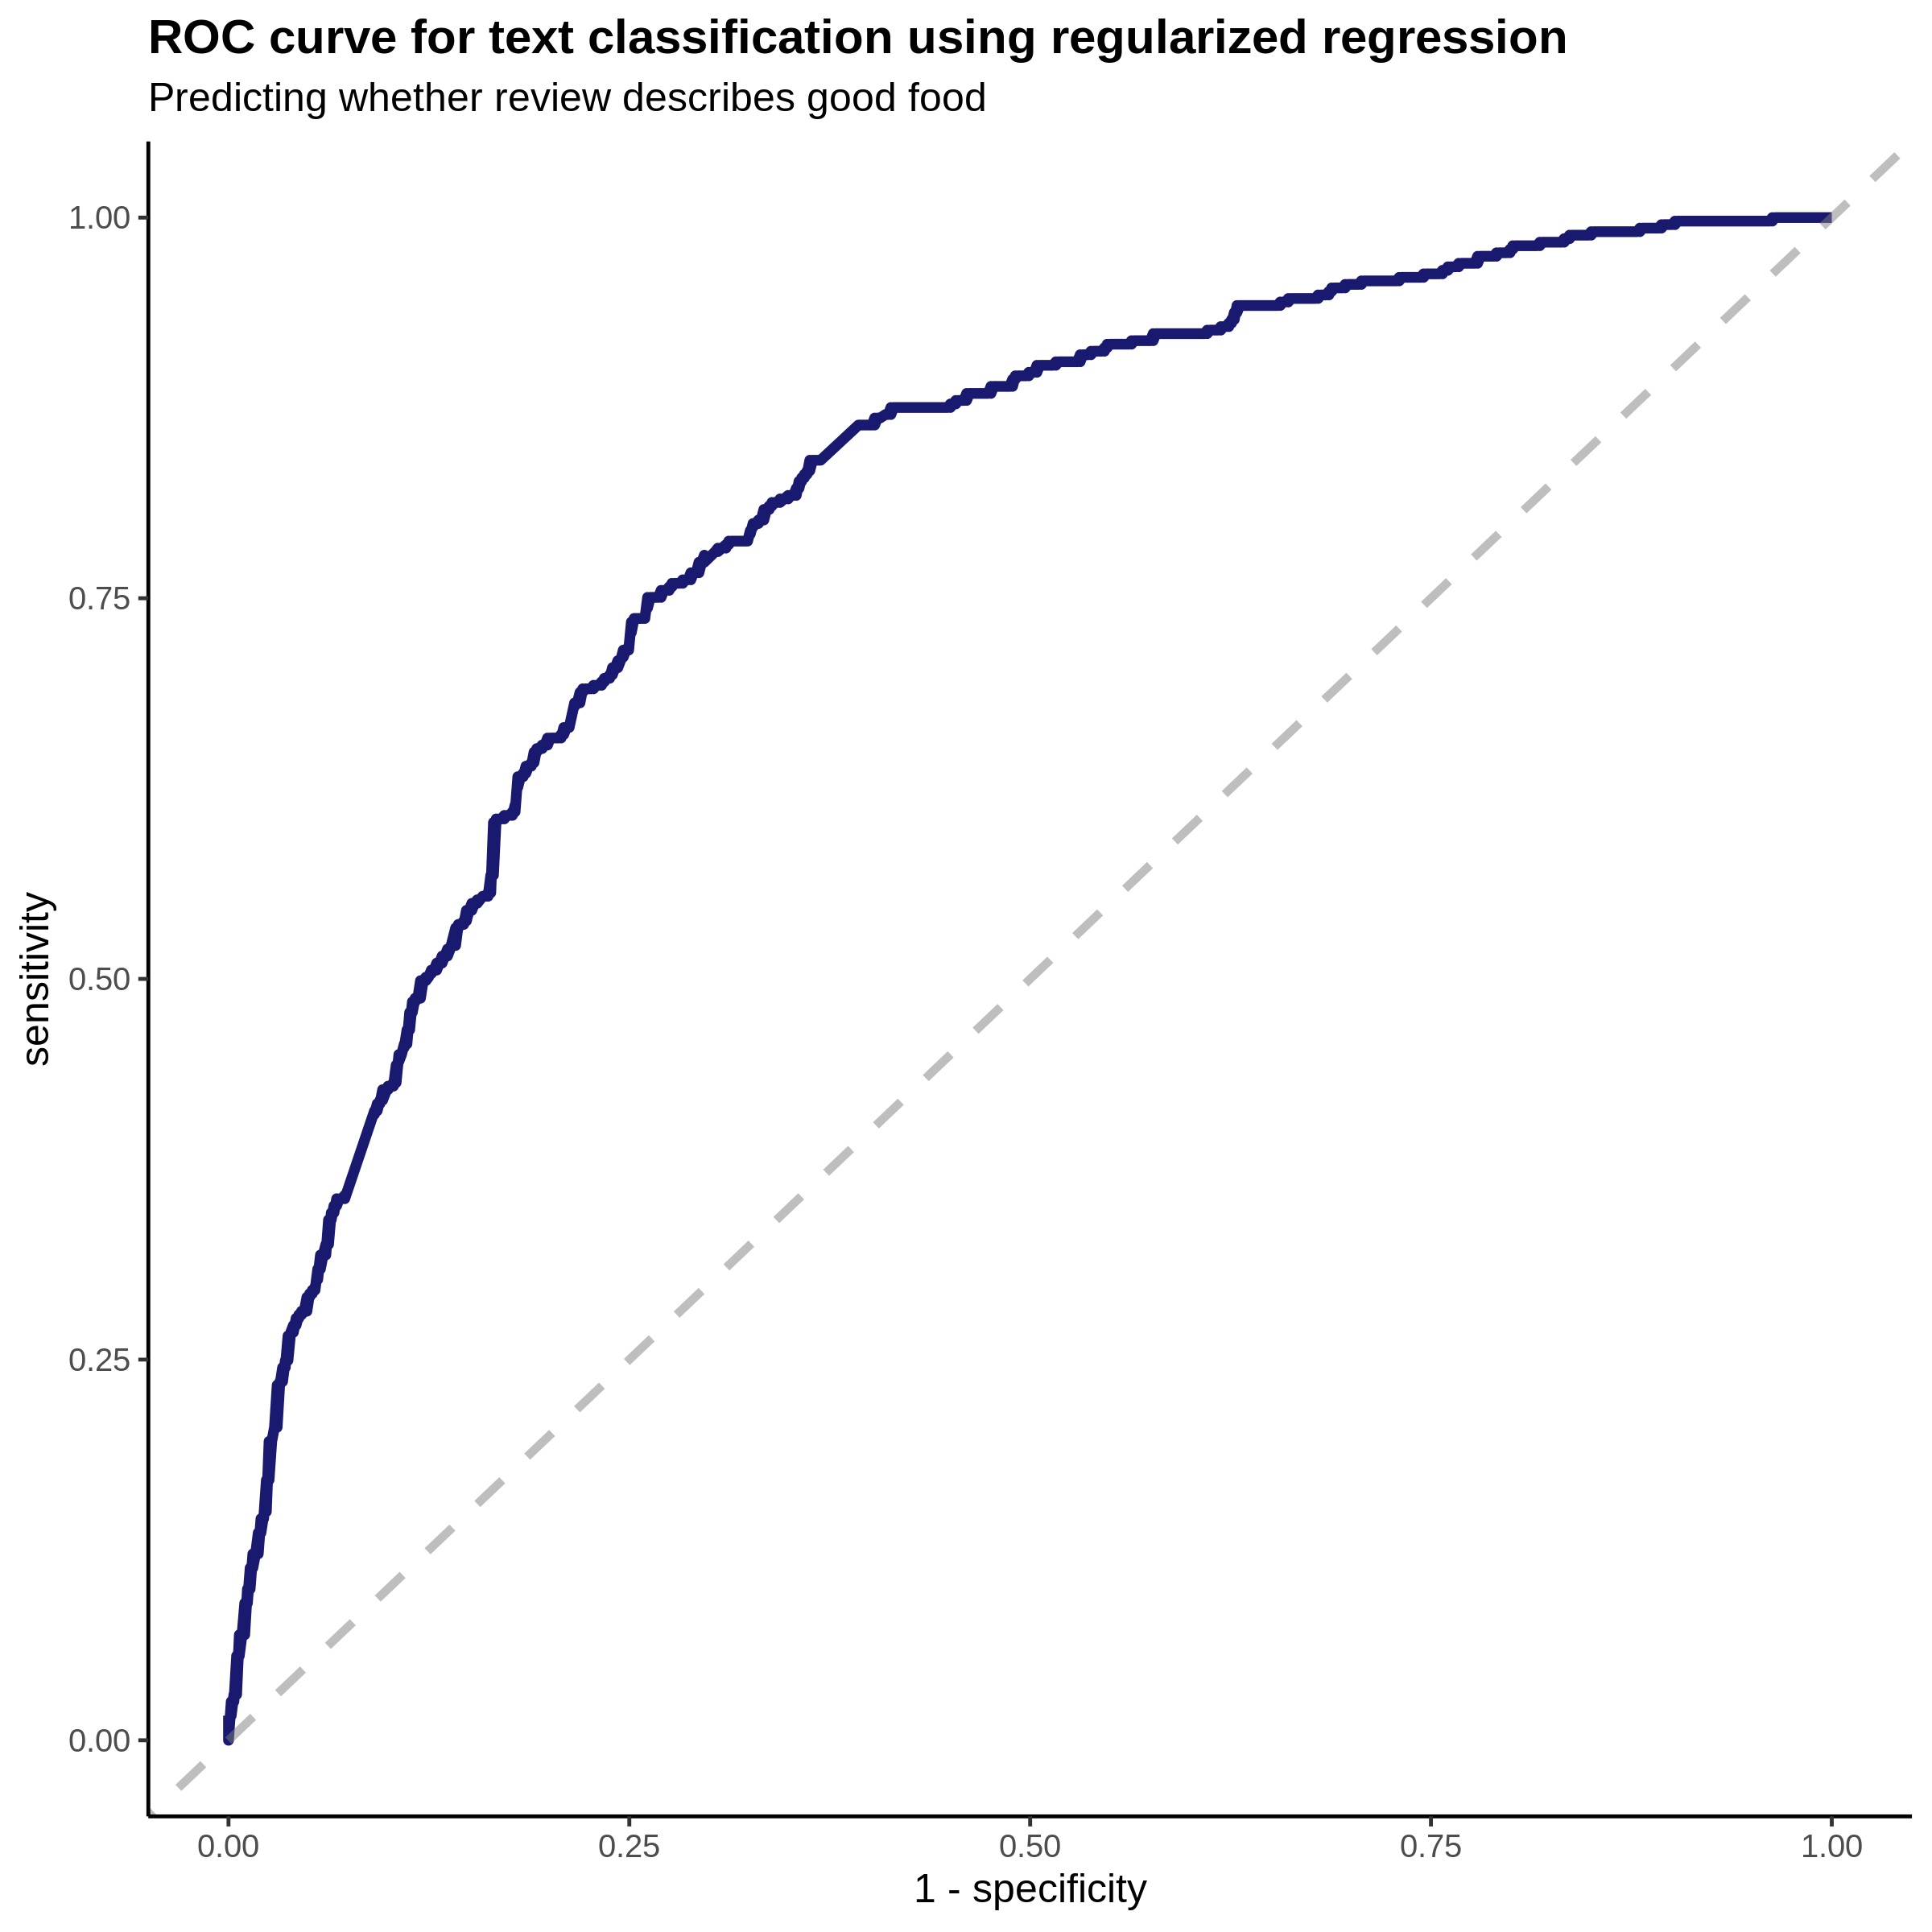

In [26]:
# ROC curve 
comment_classes <- classifications %>%
  left_join(
  reviews %>%
    select(target, document) , by = "document") %>%
  mutate(target = as.factor(target))

comment_classes %>%
  roc_curve(target, probability) %>%
  ggplot(aes(x = 1 - specificity, y = sensitivity)) +
  geom_line(
    color = "midnightblue",
    size = 1.5
  ) +
  geom_abline(
    lty = 2, alpha = 0.5,
    color = "gray50",
    size = 1.2
  ) +
  labs(
    title = "ROC curve for text classification using regularized regression",
    subtitle = "Predicting whether review describes good food"
  ) +
  theme_classic(base_size = 12) +
  theme(plot.title = element_text(lineheight=.8, face="bold"))

In [27]:
# area under curve
auc <- comment_classes %>%
  roc_auc(target, probability)
auc

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8046941


In [28]:
# confusion marix
comment_classes %>%
  mutate(prediction = case_when(
          probability > 0.5 ~ "High",
          TRUE ~ "Low"),
        prediction = as.factor(prediction)) %>%
  conf_mat(target, prediction)

          Truth
Prediction High Low
      High  258  98
      Low   175 495

In [29]:
# accuracy
comment_classes %>%
  mutate(prediction = case_when(
          probability > 0.5 ~ "High",
          TRUE ~ "Low"),
        prediction = as.factor(prediction)) %>%
  accuracy(target, prediction)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7339181


In [30]:
# check false positive
comment_classes %>%
  filter(probability > .8,
          target == "Low") %>%
#  sample_n(10) %>%
  inner_join(reviews %>%
  select(document, reviewText, target)) %>%
  select(probability, reviewText, target)


Joining, by = c("document", "target")


probability,reviewText,target
<dbl>,<chr>,<chr>
0.8354598,heerlijk gegeten nagenoeg alles was goed tot bijna perfect super lekkere carpaccio genoeg voor twee man heerlijke pasta en pizza gerechten afgesloten met een toetje waar ik nu nog steeds van moet watertanden bediening ook uiterst attent wat een absoluut unicum is gezien de lage leeftijd niets anders dan lof voor deze jongens en meisjes in de bediening wij gaan hier zeker nog vaak terug komen,Low
0.8035102,heerlijk gegeten in het nieuwe restaurant aan de rijn in de leidse binnenstad er was keuze uit diverse kleine warme en koude gerechtjes door de vriendelijke bediening werden we geadviseerd 4 à 5 gerechtjes te kiezen dit staat ongeveer gelijk aan een voor en hoofdgerecht we hebben 2 rondes besteld de gerechtjes werden voor ons alle vier op een groot plateau geserveerd de eerst ronde at ik heerlijke bruschetta's en een lekkere vitella tonnato de volgende gang een heerlijk malse kalsribeye en zalige roseval aardappeltjes heerlijke wijn erbij maakte het compleet we hebben een heerlijke avond gehad met vrienden in dit gezellige restaurantje met uiterst vriendelijke bediening we hebben nog niet alle gerechtjes geprobeerd dus we komen zeker terug,Low


# References:
https://juliasilge.com/blog/tidy-text-classification/

# Extras

In [31]:
# starter for tags manipulation
#tags <- reviews %>% select(restoId, tags) %>% distinct() %>% drop_na() %>% 
#  unnest_tokens(tag, tags, token = strsplit, split = "|", fixed=T)
#tags %>%
#  count(tag, sort = TRUE) 